In [1]:
import pickle as pkl
import networkx as nx 
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.cm as cm
import seaborn as sns
import math
# %matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import sys
import pyLDAvis
import pyLDAvis.gensim
import operator
stdout = sys.stdout
reload(sys)
sys.setdefaultencoding('utf-8')
sys.stdout = stdout
import random
import powerlaw
import copy
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from tqdm import tqdm
from ipywidgets import FloatProgress
from IPython.display import display
from scipy.stats import sem
from random import choice
import matplotlib._color_data as mcd

In [2]:
plt.style.use('seaborn-white')

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12

In [3]:
import logging
logger = logging.getLogger()
fhandler = logging.FileHandler(filename='../Logs/GraphAnalysis.log', mode='a')
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fhandler.setFormatter(formatter)
logger.addHandler(fhandler)
logger.setLevel(logging.DEBUG)

In [4]:
# def drawUserGraph(graph):
#     ugraph = graph
#     pos = graphviz_layout(ugraph, prog='neato')

#     usr = ugraph.nodes()
#     print len(usr)
#     color=cm.rainbow(np.linspace(0,1,len(usr)))
#     colorMap = []
#     lls = {}
#     for node in ugraph:
#         c = usr.index(node)
#         colorMap.append(color[c])
#         lls[node] = node
#     fig, ax = plt.subplots()
#     fig.set_size_inches(40, 30)
#     #
#     nx.draw(ugraph,pos=pos ,node_color=colorMap , with_labels = True , labels = lls , font_size=25)
#     plt.show()
    
def findMedianCentrality(graph):
    return np.median(nx.closeness_centrality(graph.to_undirected()).values())

def getEdgeWeights(graph):
    weightList = []
    for u,v,d in graph.edges(data=True):
        weightList.append(d['weight'])
    return weightList

def findTopicalEdgeWeight(graph,nodes):
    weightList = []
    for u,v,d in graph.edges(data=True):
        if (u in nodes or v in nodes):
            weightList.append(d['weight'])
    if len(weightList) > 0:
        return np.median(weightList)
    else:
        print "Did not find a single OP post, Weird :/"
        return None

def findMaxWeightSpread(graph):
    edges = graph.edges(data=True)
    edgeTopics = [e[2]['weight'] for e in edges]
    return (float(max(edgeTopics)) - float(min(edgeTopics)))

def findMaxTopicSpread(graph):
    g = copy.deepcopy(graph)
    topicSpreads = []
    for u,v,d in g.edges(data=True):
        if graph.has_edge(v,u):
            topicSpread = d['weight'] - g[v][u]['weight']
            topicSpreads.append(topicSpread)
            g.remove_edge(v,u)
    if len(topicSpreads) > 0:
        ans = np.std(topicSpreads)
    else:
        ans = None
    return ans

def getTopicDistribution(graphDict):
    alignments = []
    for k in graphDict:
        for e in graphDict[k].edges(data=True):
            alignments.append(e[2]['weight'])
    return alignments

def getTopicdist(graphDict, opDict = None):
    spreads = []
    alignments = []
    for k in graphDict:
        alignment = 0.0
        if opDict == None:
            alignment = findTopicalEdgeWeight(graphDict[k] , graphDict[k].nodes())
        else:
            if k in opDict:
                print "Finding OP Topical Alignment"
                alignment = findTopicalEdgeWeight(graphDict[k] , opDict[k])
            else:
                print "OP node nwas not ther in passed dictionary" 
        if alignment != None:  
            alignments.append(alignment)
        
        spread = findMaxTopicSpread(graphDict[k])
        if spread!=None:
            spreads.append(spread)
            
    return alignments,spreads
        

def getMetrics(graphDict,opDict=None):
    metricDict = {}
    medCentralities = []
    opCentrality = []
    medClusterings = []
    for k in graphDict:
        metricDict[k] = {}
        centralities = nx.closeness_centrality(graphDict[k].to_undirected())
        medCentrality = np.median(centralities.values())
        medClustering = np.median(nx.clustering(graphDict[k].to_undirected()).values())
        medianTA = np.median(getEdgeWeights(graphDict[k]))
        metricDict[k]['medTA'] = medianTA
        if opDict:
            if k in opDict and opDict[k] in centralities:
                if opDict[k] == '[deleted]':
                    print "op was Deleted"
                else:
                    opCentrality.append(centralities[opDict[k]])
                    metricDict[k]['opCentrality'] = centralities[opDict[k]]
        if np.isnan(medCentrality):
            print "Found Nan centrality"
            continue
        else:
            medCentralities.append(medCentrality)
            metricDict[k]['medCentrality'] = medCentrality
                                                                  
        
        if np.isnan(medClustering):
            print "Found Nan Clustering"
            continue
        else:
            medClusterings.append(medClustering)
            metricDict[k]['medClustering'] = medClustering
        
    return medClusterings , medCentralities , opCentrality , metricDict


def getScaledSizes(graph):
    affects = nx.get_node_attributes(graph, 'affects')
    s = [int(affects[v]) for v in graph.nodes()]
    normed = [i + 1000 for i in s]
    scaled = [v*(2^(v-np.min(normed)))+100 for v in normed]
    return scaled

def drawReplyGraph(graph):
    cascadeGraph = graph
    sizes = getScaledSizes(cascadeGraph)
    pos = graphviz_layout(cascadeGraph, prog='neato')

    usr = list(set(nx.get_node_attributes(cascadeGraph, 'author').values()))
    color=cm.rainbow(np.linspace(0,1,len(usr)))
    colorMap = []
    lls = {}
    for node in cascadeGraph:
        c = usr.index(cascadeGraph.node[node]['author'])
        colorMap.append(color[c])
        lls[node] = cascadeGraph.node[node]['author']
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 8)
    nx.draw(cascadeGraph,pos=pos ,node_size=sizes ,node_color=colorMap , with_labels = True , labels = lls , font_size=25)
    plt.show()

def drawUserGraph(graph):
    ugraph = graph
    pos = graphviz_layout(ugraph, prog='neato')
    usr = ugraph.nodes()
    print len(usr)
    color=cm.rainbow(np.linspace(0,1,len(usr)))
    colorMap = []
    lls = {}
    for node in ugraph:
        c = usr.index(node)
        colorMap.append(color[c])
        lls[node] = node
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 8)
    #
    nx.draw(ugraph,pos=pos ,node_color=colorMap ,node_size=1500, with_labels = True , labels = lls , font_size=25)
    plt.show()
    
def cleanRepllGraphs(graphs):
    nodes = 0
    empty = 0
    for k in graphs:
        digraph = graphs[k]
        for n in digraph.nodes(data=True):
            nodes+=1
            if n[1]['text'] =='' or n[1]['text'] == '[deleted]' or n[1]['text'] == '[removed]':
                empty +=1
                
    return nodes, empty

In [5]:
SW_Graphs= pkl.load(open("../Data/SW_TopicUgraphs_Doc2Vec_Cosine.pkl",'rb'))
BL_Graphs= pkl.load(open("../Data/BL_TopicUgraphs_Doc2Vec_Cosine.pkl",'rb'))

In [6]:
# ReplyGraphs_SW = pkl.load(open("../Data/reddit_suicideWatch/SW_allValidThreads_graphs/SW_Allvalid_Graphs_Depth_fixed.pkl",'rb'))
ReplyGraphs_SW = pkl.load(open("../Data/SW_TopicReplygraphs_Doc2Vec_Cosine.pkl",'rb'))
# ReplyGraphs_BL = pkl.load(open("../Data/FrontPage/graphs/frontPage_replygraphs_50k.pkl",'rb'))
ReplyGraphs_BL = pkl.load(open("../Data/BL_TopicReplygraphs_Doc2Vec_Cosine.pkl",'rb'))

In [7]:
Dep_Graphs = pkl.load(open("../Data/Dep_TopicUgraphs_Doc2Vec_Cosine.pkl",'rb'))
ReplyGraphs_Dep = pkl.load(open("../Data/Dep_TopicReplygraphs_Doc2Vec_Cosine.pkl",'rb'))

In [8]:
# Dep_Graphs[Dep_Graphs.keys()[1]].nodes(data=True)

In [9]:
# UserGraphs_SW = pickle.load(open("../Data/SW_TopicUgraphs.pkl",'rb'))
# UserGraphs_BL = pickle.load(open("../Data/BL_TopicUgraphs.pkl",'rb'))

In [10]:
with(open("SavedObjs/SW_OpAuthors_2.pkl",'rb')) as f:
    SW_OpAuthors = pkl.load(f)

with(open("SavedObjs/BL_OpAuthors_2.pkl",'rb')) as f:
    FP_OpAuthors = pkl.load(f)

with(open("Dep_opAuthors_sampled_01.pkl",'rb')) as f:
    Dep_OpAuthors = pkl.load(f)

In [11]:
print len(set(SW_OpAuthors.keys()).intersection(SW_Graphs.keys()))
print len(set(FP_OpAuthors.keys()).intersection(BL_Graphs.keys()))
print len(set(Dep_OpAuthors.keys()).intersection(Dep_Graphs.keys()))

10527
11070
846


In [12]:
SW_medClusterings , SW_medCentralities, SW_opCentralities, SW_metricDict  = getMetrics(SW_Graphs,SW_OpAuthors)

In [13]:
Dep_medClusterings , Dep_medCentralities, Dep_opCentralities, Dep_metricDict  = getMetrics(Dep_Graphs,Dep_OpAuthors)

In [14]:
BL_medClusterings , BL_medCentralities , BL_opCentralities, BL_metricDict  =  getMetrics(BL_Graphs,FP_OpAuthors)

In [15]:
ReplyGraphs_BL[BL_Graphs.keys()[1]].nodes(data= True)

[(u't1_duwkb9f',
  {'affects': 25.77,
   'author': u'dokkan_throwaway',
   'depth': 0,
   'downs': 0,
   'text': 'Me pergunto onde eles estavam quando a Dilma escondia o buraco das contas p\xc3\xbablicas no Banco do Brasil, na Caixa e no BNDES.',
   'time': 1519738654.0,
   'ups': -8}),
 (u't3_80m5ld',
  {'affects': 0.0,
   'author': u'pizzaiolo_',
   'depth': -1,
   'downs': 0,
   'text': '',
   'time': 1519735561.0,
   'ups': 78}),
 (u't1_dux5awl',
  {'affects': 99.0,
   'author': u'dokkan_throwaway',
   'depth': 4,
   'downs': 0,
   'text': 'Ok ent\xc3\xa3o, obrigado pela sua contribui\xc3\xa7\xc3\xa3o.',
   'time': 1519759406.0,
   'ups': -2}),
 (u't1_dux0e7d',
  {'affects': 25.77,
   'author': u'JudicialApe',
   'depth': 2,
   'downs': 0,
   'text': 'Nota 10 em geopol\xc3\xadtica. /s',
   'time': 1519754961.0,
   'ups': 12}),
 (u't1_duwi8uf',
  {'affects': 31.37,
   'author': u'NemLiNemLereiBot',
   'depth': 0,
   'downs': 0,
   'text': '^(Este \xc3\xa9 o melhor NL;NL que eu pude 

In [16]:
def getcentralityDict(d,key):
    cent = {}
    for l in tqdm(d):
        if key in d[l]:
            cent[l] = d[l][key]
    return cent

BL_centDict = getcentralityDict(BL_metricDict,'medCentrality')
SW_centDict = getcentralityDict(SW_metricDict,'medCentrality')
BL_TA = getcentralityDict(BL_metricDict,'medTA')
SW_TA = getcentralityDict(SW_metricDict,'medTA')

BL_sorted  = sorted(BL_centDict.items(), key=operator.itemgetter(1)) 
SW_sorted  = sorted(SW_centDict.items(), key=operator.itemgetter(1)) 

BL_sorted_TA  = sorted(BL_TA.items(), key=operator.itemgetter(1)) 
SW_sorted_TA  = sorted(SW_TA.items(), key=operator.itemgetter(1))         

In [17]:
ReplyGraphs_SW['g5u9u'].nodes(data=True)

[(u't1_c1l4ei8',
  {'affects': 25.77,
   'author': u'[deleted]',
   'depth': 0,
   'downs': 0,
   'text': '[deleted]',
   'time': 1300374963.0,
   'ups': 1}),
 (u't1_c1l4l0c',
  {'affects': 99.0,
   'author': u'Psy-Kosh',
   'depth': 2,
   'downs': 0,
   'text': 'Well, I say you are worth it, so there.',
   'time': 1300377117.0,
   'ups': 1}),
 (u't1_c1l4cwv',
  {'affects': 99.0,
   'author': u'missforeverhurting',
   'depth': 3,
   'downs': 0,
   'text': 'maybe i should answer that.. not sure how to.',
   'time': 1300374421.0,
   'ups': 2}),
 (u't1_c1l4fm1',
  {'affects': 85.87,
   'author': u'[deleted]',
   'depth': 0,
   'downs': 0,
   'text': 'Bullshit!!!You are worth it!Here I am sitting at work typing this because I want you to know that people do care about their fellow man or woman.',
   'time': 1300375332.0,
   'ups': 2}),
 (u't1_c1l4aga',
  {'affects': 25.77,
   'author': u'swampsparrow',
   'depth': 1,
   'downs': 0,
   'text': "what's going on?",
   'time': 1300373593.0,
  

In [18]:
edgeWeights = []
for k in ReplyGraphs_BL:
    graph = ReplyGraphs_BL[k]
    for e in graph.edges(data=True):
        edgeWeights.append(e[2]['weight'])

In [19]:
nodes , empty = cleanRepllGraphs(ReplyGraphs_BL)
print nodes , empty

869181 24902


#Get Branching factor of reply graphs 
%latex $$\frac{ \sum_{d \in D}^{}  \frac{\sum_{n\in N_d}^{} \textit{InDeg}(n)}{|N_d|}}{|D|}$$

In [20]:
import collections
def getBranchingFactor(replyGraphDict):
    branchingFactor = {}
    for k in replyGraphDict:
        repGraph = replyGraphDict[k]
        depthDict = {}
        for n in repGraph.nodes(data=True):
            if not n[1]:
                print "found a node with malformed data %s in graph %s"%(n[0], k)
                continue
            if n[1]['depth'] not in depthDict:
                depthDict[n[1]['depth']] = []
            depthDict[n[1]['depth']].append(n[0])
        od = collections.OrderedDict(sorted(depthDict.items()))
#         print od
        lengths = []
        for key, value in od.items():
            lengths.append(len(value))
        diffs = [float(t)/float(s) for s, t in zip(lengths, lengths[1:])]
        branchingFactor[k] = [np.mean(diffs) , np.median(diffs) , np.max(diffs)]
    return branchingFactor

# def parseGraph(graph, node, stack , returnList ):
    
def cleanAndSort(l) :
    s = list(set(l))
    s.sort()
    return s

def getReturnDiffs(depthList):
    diffs = [t-s for s, t in zip(depthList, depthList[1:])]
    if np.isnan(np.mean(diffs)):
        print "found nan difference"
        print diffs
        return [0.0,0.0]
    else:
        return [np.mean(diffs),np.mean(depthList)]
    
def meanReturnAuthorDistance(replyGraphDict,selectAuthors=None):
    returnFactorDict = {}
    for g in replyGraphDict:
        returnVals = []
        repGraph = replyGraphDict[g]
        authorDict = {}
        for n in repGraph.nodes(data=True):
            if not n[1]:
                print "found a node with malformed data %s in graph %s"%(n[0], g)
                continue
            if n[1]['author'] not in authorDict:
                authorDict[n[1]['author']] = []
            else:
                authorDict[n[1]['author']].append(n[1]['depth'])
        for k in authorDict:
            authorDict[k] = cleanAndSort(authorDict[k])
        if selectAuthors==None:
            selectList = authorDict.keys()
        else:
            selectList = selectAuthors[g]
        for k in authorDict:
            if k in selectList:
                if len(authorDict[k]) > 1:
                    returnFactorDict[g] = getReturnDiffs(authorDict[k])
    return returnFactorDict

In [ ]:
len(ReplyGraphs_BL) , leb(ReplyGraphs_SW)

In [21]:
BL_opReturnFactor = meanReturnAuthorDistance(ReplyGraphs_BL, FP_OpAuthors)

In [22]:
BL_ReturnFactor = meanReturnAuthorDistance(ReplyGraphs_BL)

In [23]:
SW_opReturnFactor = meanReturnAuthorDistance(ReplyGraphs_SW, SW_OpAuthors)

found a node with malformed data t3_g5rqg in graph g5u9u


In [24]:
SW_ReturnFactor = meanReturnAuthorDistance(ReplyGraphs_SW)

found a node with malformed data t3_g5rqg in graph g5u9u


Text(0.5,0,'Return to conversation distance')

Text(0,0.5,'P(x) < y')

(array([ 0.,  2.,  4.,  6.,  8., 10., 12.]),
 <a list of 7 Text xticklabel objects>)

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2]),
 <a list of 7 Text yticklabel objects>)

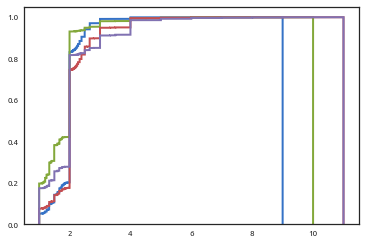

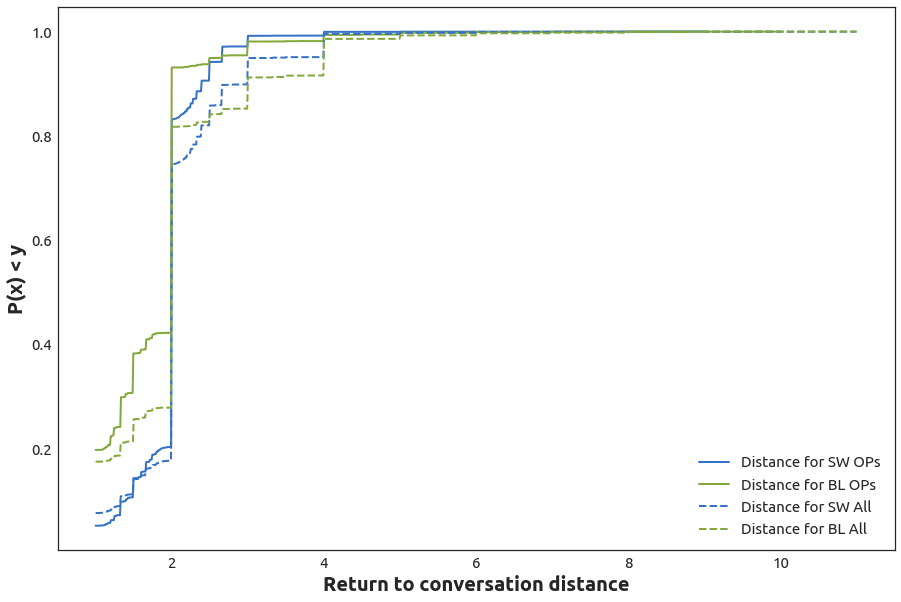

In [25]:
n1 , bins1 , patches1 = plt.hist([SW_opReturnFactor[k][0] for k in SW_opReturnFactor], 1000, normed=1,histtype='step', cumulative=True,linewidth = 2.0)
n2 , bins2 , patches2 = plt.hist([BL_opReturnFactor[k][0] for k in BL_opReturnFactor], 1000, normed=1,histtype='step', cumulative=True,linewidth = 2.0)
n3 , bins3 , patches3 = plt.hist([SW_ReturnFactor[k][0] for k in SW_ReturnFactor], 1000, normed=1,histtype='step', cumulative=True,linewidth = 2.0)
n4 , bins4 , patches4 = plt.hist([BL_ReturnFactor[k][0] for k in BL_ReturnFactor], 1000, normed=1,histtype='step', cumulative=True,linewidth = 2.0)


fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
ax.plot(bins1[:-1], n1, 'b', linewidth=2)
ax.plot(bins2[:-1], n2, 'g', linewidth=2)
ax.plot(bins3[:-1], n3, 'b--', linewidth=2)
ax.plot(bins4[:-1], n4, 'g--', linewidth=2)

# plt.title("Clustering of User interaction Graphs", fontsize = 20)
plt.xlabel("Return to conversation distance",fontsize = 20)
plt.ylabel("P(x) < y",fontsize = 20)
plt.legend(['Distance for SW OPs','Distance for BL OPs','Distance for SW All','Distance for BL All'], loc='lower right',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.grid()
plt.show()

Text(0.5,0,'Mean posting depth (log10)')

Text(0,0.5,'P(x) < y')

(array([-0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5]),
 <a list of 7 Text xticklabel objects>)

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 <a list of 8 Text yticklabel objects>)

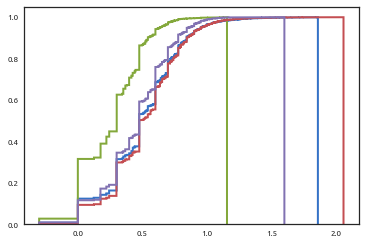

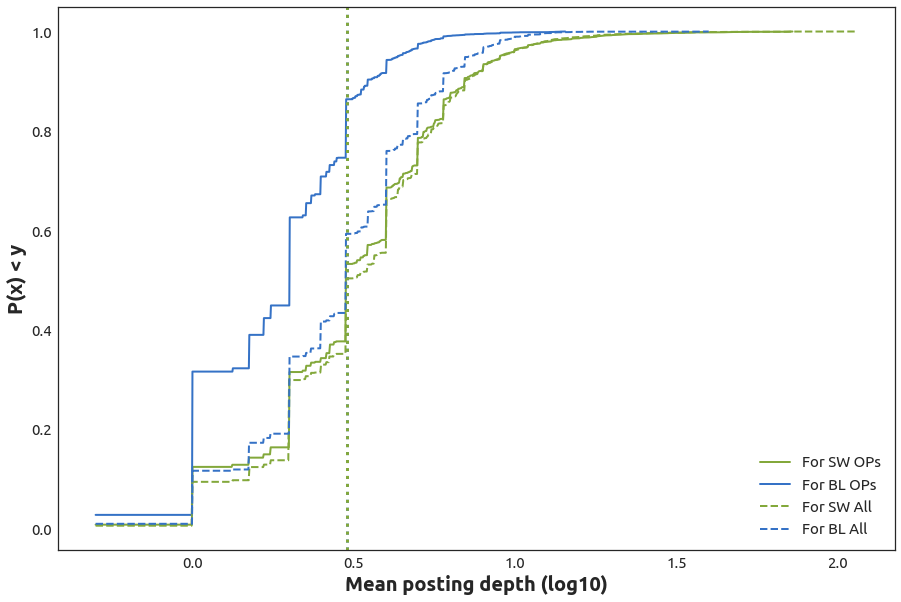

In [26]:
n1 , bins1 , patches1 = plt.hist(np.log10([SW_opReturnFactor[k][1]+1 for k in SW_opReturnFactor]), 1000, normed=1,histtype='step', cumulative=True,linewidth = 2.0)
n2 , bins2 , patches2 = plt.hist(np.log10([BL_opReturnFactor[k][1]+1 for k in BL_opReturnFactor]), 1000, normed=1,histtype='step', cumulative=True,linewidth = 2.0)
n3 , bins3 , patches3 = plt.hist(np.log10([SW_ReturnFactor[k][1]+1 for k in SW_ReturnFactor]), 1000, normed=1,histtype='step', cumulative=True,linewidth = 2.0)
n4 , bins4 , patches4 = plt.hist(np.log10([BL_ReturnFactor[k][1]+1 for k in BL_ReturnFactor]), 1000, normed=1,histtype='step', cumulative=True,linewidth = 2.0)


fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
ax.plot(bins1[:-1], n1, 'g', linewidth=2)
ax.plot(bins2[:-1], n2, 'b', linewidth=2)
ax.plot(bins3[:-1], n3, 'g--', linewidth=2)
ax.plot(bins4[:-1], n4, 'b--', linewidth=2)


ax.axvline(x=np.median(np.log10([BL_ReturnFactor[k][1]+1 for k in BL_ReturnFactor])), ymin=0, ymax=1, linewidth=3, color = 'b', linestyle='dotted')
ax.axvline(x=np.median(np.log10([SW_ReturnFactor[k][1]+1 for k in SW_ReturnFactor])), ymin=0, ymax=1, linewidth=3, color = 'g', linestyle='dotted')


# plt.title("Clustering of User interaction Graphs", fontsize = 20)
plt.xlabel("Mean posting depth (log10)",fontsize = 20)
plt.ylabel("P(x) < y",fontsize = 20)
plt.legend(['For SW OPs','For BL OPs','For SW All','For BL All'], loc='lower right',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.grid()
plt.show()

In [27]:
SW_branching = getBranchingFactor(ReplyGraphs_SW)

found a node with malformed data t3_g5rqg in graph g5u9u


In [28]:
BL_branching = getBranchingFactor(ReplyGraphs_BL)

In [29]:
Dep_branching = getBranchingFactor(ReplyGraphs_Dep)

In [30]:
import seaborn as sns

In [31]:
sns.set_style('whitegrid')

Text(0.5,0,'Distribution of mean Branching factor per thread')

Text(0,0.5,'Frequency')

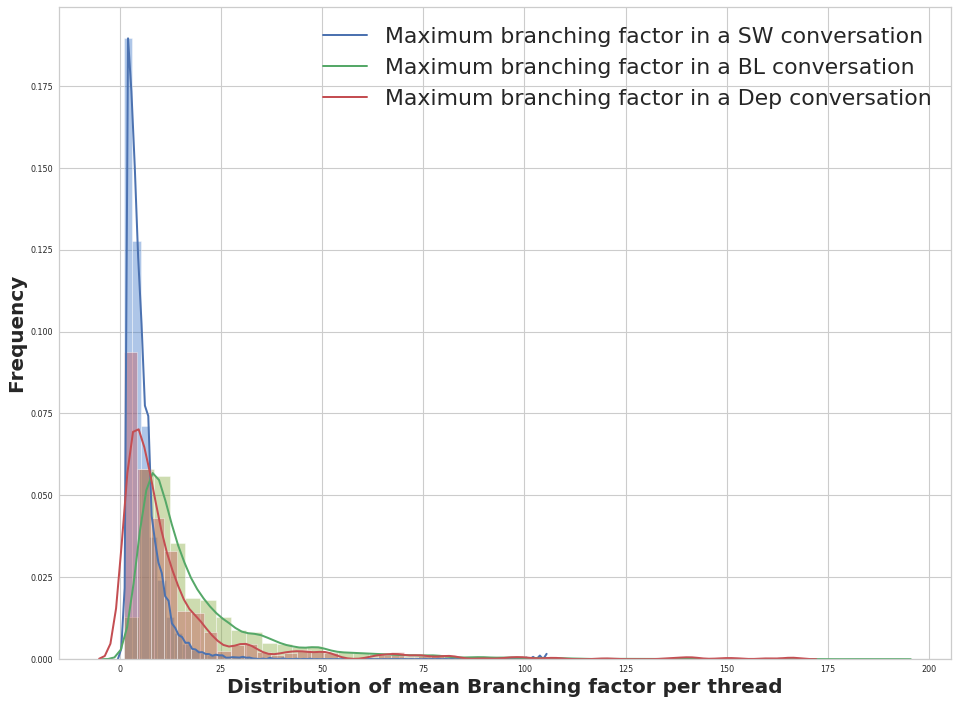

In [32]:
fig, ax = plt.subplots()
fig.set_size_inches(16,12)
sns.set(font_scale=2) 
sns.distplot([SW_branching[k][2] for k in SW_branching],kde_kws={"color": "b", "lw": 2, "label": "Maximum branching factor in a SW conversation"})
sns.distplot([BL_branching[k][2] for k in BL_branching],kde_kws={"color": "g", "lw": 2, "label": "Maximum branching factor in a BL conversation"})
sns.distplot([Dep_branching[k][2] for k in Dep_branching],kde_kws={"color": "r", "lw": 2, "label": "Maximum branching factor in a Dep conversation"})
# ax.axvline(x=np.median(medTopicalSW), ymin=0, ymax=1, linewidth=3, color = 'b', linestyle='dotted')
# ax.axvline(x=np.median(medTopicalBL), ymin=0, ymax=1, linewidth=3, color = 'g', linestyle='dotted')
plt.xlabel("Distribution of mean Branching factor per thread" , fontsize = 20)
plt.ylabel("Frequency" , fontsize = 20 )

In [33]:
BL_sorted_TA[-10:]

[(u'81x49o', 0.8702167451381684),
 (u'7zwkaq', 0.8802485346794129),
 (u'7zvu84', 0.8953911542892456),
 (u'819aaf', 0.9012245416641236),
 (u'825c7z', 0.9312152147293091),
 (u'7zmkq8', 0.9361676454544068),
 (u'80lsw5', 0.9406222879886628),
 (u'7z46vs', 0.9507737040519715),
 (u'814gcj', 0.9507791876792908),
 (u'80lwfx', 0.953444528579712)]

35


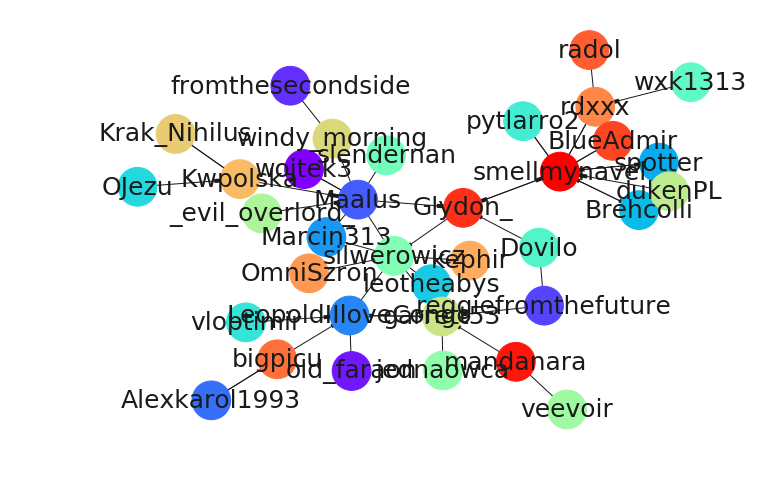

In [34]:
drawUserGraph(BL_Graphs[BL_sorted_TA[-10][0]])

2


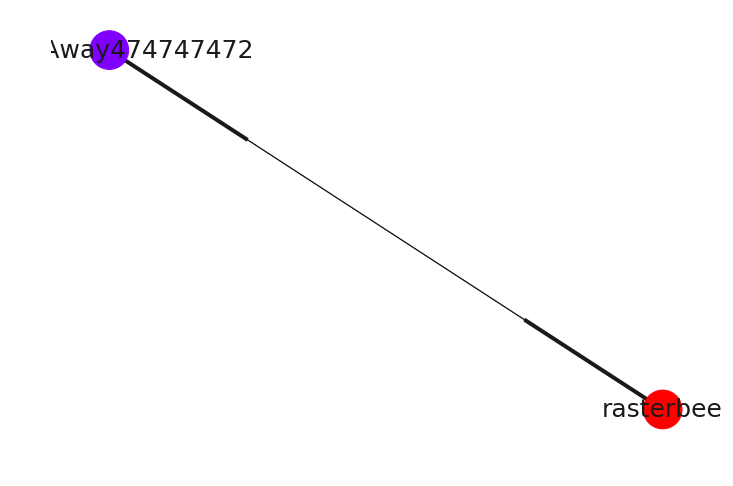

In [35]:
drawUserGraph(SW_Graphs[SW_sorted_TA[-15][0]])

In [36]:
len(BL_medCentralities) , len(SW_medCentralities)

(11070, 10527)

In [37]:
BL_medCentralities

[0.43315508021390375,
 0.3939393939393939,
 0.45,
 0.48333333333333334,
 0.22613065326633167,
 0.475,
 0.22655169828921723,
 0.4090909090909091,
 0.2916666666666667,
 0.3076923076923077,
 0.32120905952681655,
 0.34814814814814815,
 0.47368421052631576,
 0.2536231884057971,
 0.3865546218487395,
 0.42424242424242425,
 0.3696369636963696,
 0.2981871994080651,
 0.4772727272727273,
 0.3728813559322034,
 0.4507042253521127,
 0.2810810810810811,
 0.45454545454545453,
 0.375,
 0.42857142857142855,
 0.337664615716753,
 0.3958333333333333,
 0.37037037037037035,
 0.47058823529411764,
 0.24442750797589508,
 0.4642857142857143,
 0.2777777777777778,
 0.4107142857142857,
 0.3898305084745763,
 0.48684210526315785,
 0.1915750915750916,
 0.3958333333333333,
 0.25449101796407186,
 0.42857142857142855,
 0.424,
 0.4,
 0.39473684210526316,
 0.32,
 0.4525862068965517,
 0.3335526315789474,
 0.4358974358974359,
 0.4117647058823529,
 0.40551181102362205,
 0.3776223776223776,
 0.4107142857142857,
 0.483870967741

In [38]:
# medTopicalSW , TopicalSpreadSW = getTopicMetrics(SW_Graphs)

In [42]:
# len(medTopicalSW) , len(TopicalSpreadSW)

In [43]:
# medTopicalBL , TopicalSpreadBL = getTopicMetrics(BL_Graphs)

In [44]:
# len(medTopicalBL) , len(TopicalSpreadBL)

In [45]:
print len(SW_opCentralities) , len(BL_opCentralities) , len(Dep_opCentralities)

10527 11070 846


In [46]:
len(BL_medClusterings) , len(SW_medClusterings)

(11070, 10527)

In [47]:
topicAlignmentAll_BL = getTopicdist(ReplyGraphs_BL)

In [48]:
len(topicAlignmentAll_BL[0])

11070

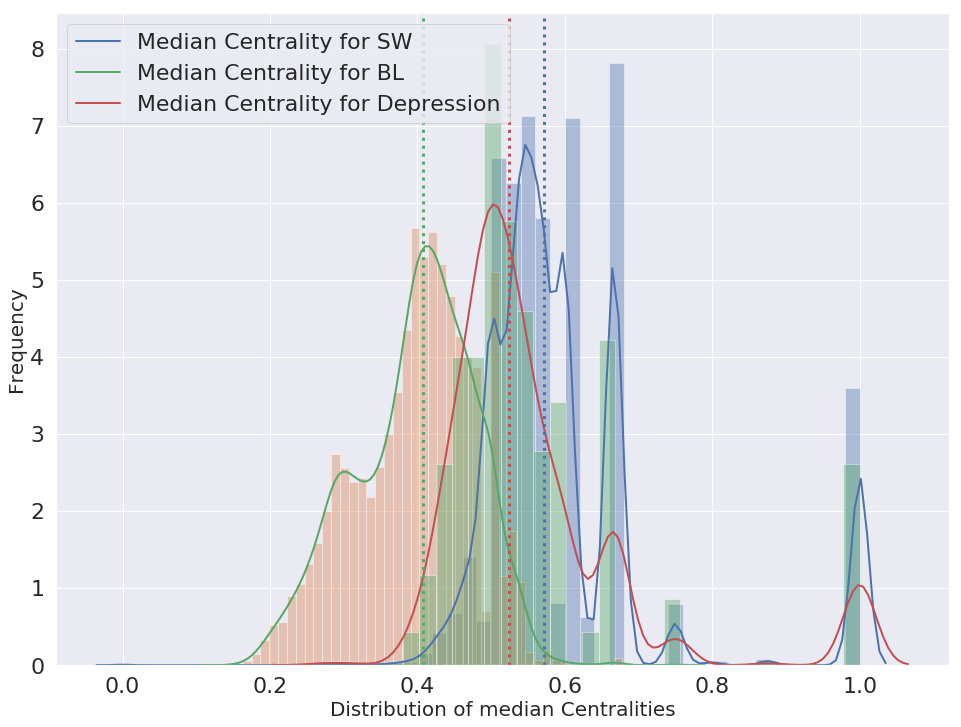

In [49]:
fig, ax = plt.subplots()
fig.set_size_inches(16,12)
sns.set(font_scale=2) 
sns.distplot(SW_medCentralities,kde_kws={"color": "b", "lw": 2, "label": "Median Centrality for SW"})
sns.distplot(BL_medCentralities,kde_kws={"color": "g", "lw": 2, "label": "Median Centrality for BL"})
sns.distplot(Dep_medCentralities,kde_kws={"color": "r", "lw": 2, "label": "Median Centrality for Depression"})
ax.axvline(x=np.median(SW_medCentralities), ymin=0, ymax=1, linewidth=3, color = 'b', linestyle='dotted')
ax.axvline(x=np.median(BL_medCentralities), ymin=0, ymax=1, linewidth=3, color = 'g', linestyle='dotted')
ax.axvline(x=np.median(Dep_medCentralities), ymin=0, ymax=1, linewidth=3, color = 'r', linestyle='dotted')
plt.xlabel("Distribution of median Centralities" , fontsize = 20)
plt.ylabel("Frequency" , fontsize = 20 )

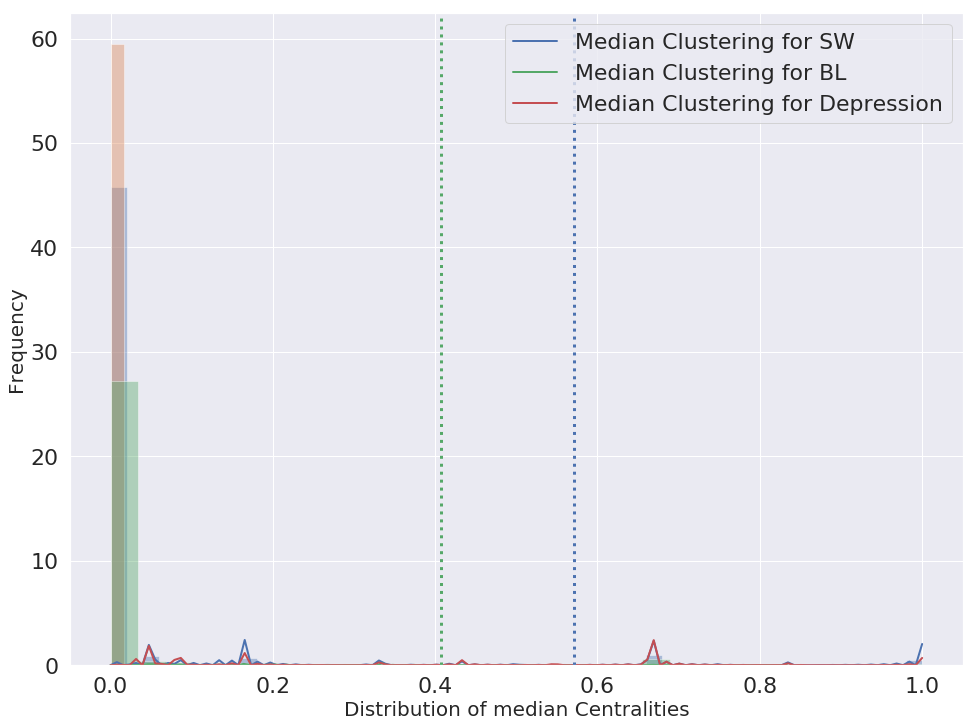

In [50]:
fig, ax = plt.subplots()
fig.set_size_inches(16,12)
sns.set(font_scale=2) 
sns.distplot(SW_medClusterings,kde_kws={"color": "b", "lw": 2, "label": "Median Clustering for SW"})
sns.distplot(BL_medClusterings,kde_kws={"color": "g", "lw": 2, "label": "Median Clustering for BL"})
sns.distplot(Dep_medClusterings,kde_kws={"color": "r", "lw": 2, "label": "Median Clustering for Depression"})
ax.axvline(x=np.median(SW_medCentralities), ymin=0, ymax=1, linewidth=3, color = 'b', linestyle='dotted')
ax.axvline(x=np.median(BL_medCentralities), ymin=0, ymax=1, linewidth=3, color = 'g', linestyle='dotted')
plt.xlabel("Distribution of median Centralities" , fontsize = 20)
plt.ylabel("Frequency" , fontsize = 20 )

In [51]:
nx.__version__

'1.9.1'

In [40]:
sns.set_style("whitegrid")

Text(0.5,1,"CDF for OP's centralities")

Text(0.5,0,"OP's centrality in a thread")

Text(0,0.5,'CDF')

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 <a list of 8 Text xticklabel objects>)

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 <a list of 8 Text yticklabel objects>)

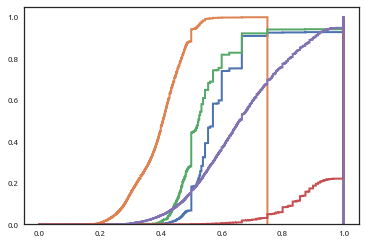

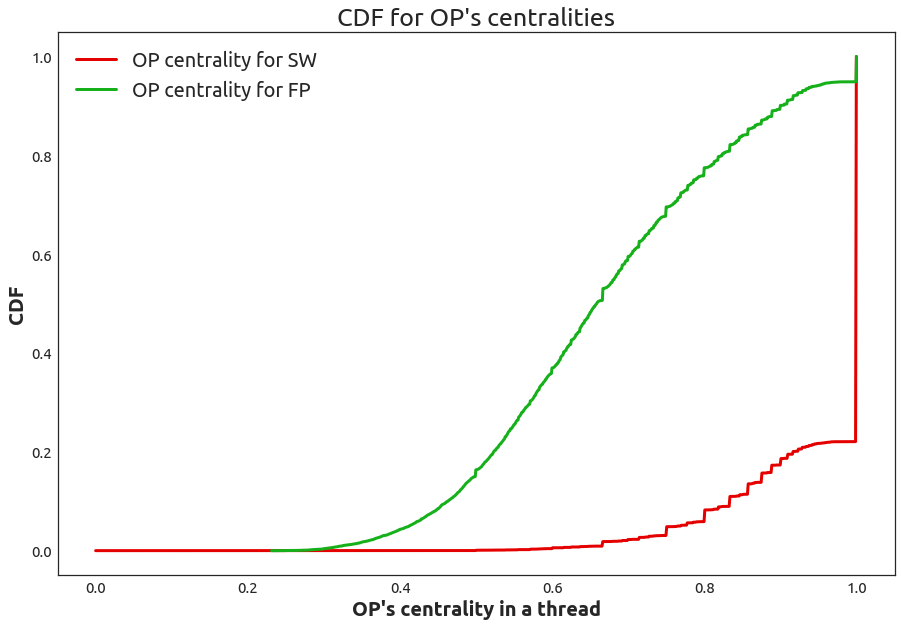

In [46]:
n1_all , bins1_all , patches1 = plt.hist(SW_medCentralities, 1000, normed=1,histtype='step', cumulative=True,linewidth = 2.0)
n2_all , bins2_all , patches2 = plt.hist(BL_medCentralities, 1000, normed=1,histtype='step', cumulative=True,linewidth = 2.0)
n3_all , bins3_all , patches3 = plt.hist(Dep_medCentralities, 1000, normed=1,histtype='step', cumulative=True,linewidth = 2.0)

n1 , bins1 , patches1 = plt.hist(SW_opCentralities, 1000, normed=1,histtype='step', cumulative=True,linewidth = 2.0)
n2 , bins2 , patches2 = plt.hist(BL_opCentralities, 1000, normed=1,histtype='step', cumulative=True,linewidth = 2.0)

fig, ax = plt.subplots()
fig.set_size_inches(15, 10)

ax.plot(bins1[:-1], n1, mcd.XKCD_COLORS['xkcd:red'], linewidth=3)
ax.plot(bins2[:-1], n2, mcd.XKCD_COLORS['xkcd:green'], linewidth=3)
# ax.plot(bins3_all[:-1], n3_all, 'r--', linewidth=2)
plt.title('CDF for OP\'s centralities',fontsize=25)
plt.xlabel("OP's centrality in a thread",fontsize = 20)
plt.ylabel("CDF",fontsize = 20)
plt.legend(['OP centrality for SW','OP centrality for FP',], loc='upper left',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.grid()
plt.show()

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 <a list of 8 Text xticklabel objects>)

(array([ 0.9 ,  0.92,  0.94,  0.96,  0.98,  1.  ,  1.02]),
 <a list of 7 Text yticklabel objects>)

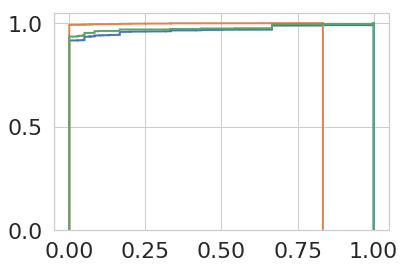

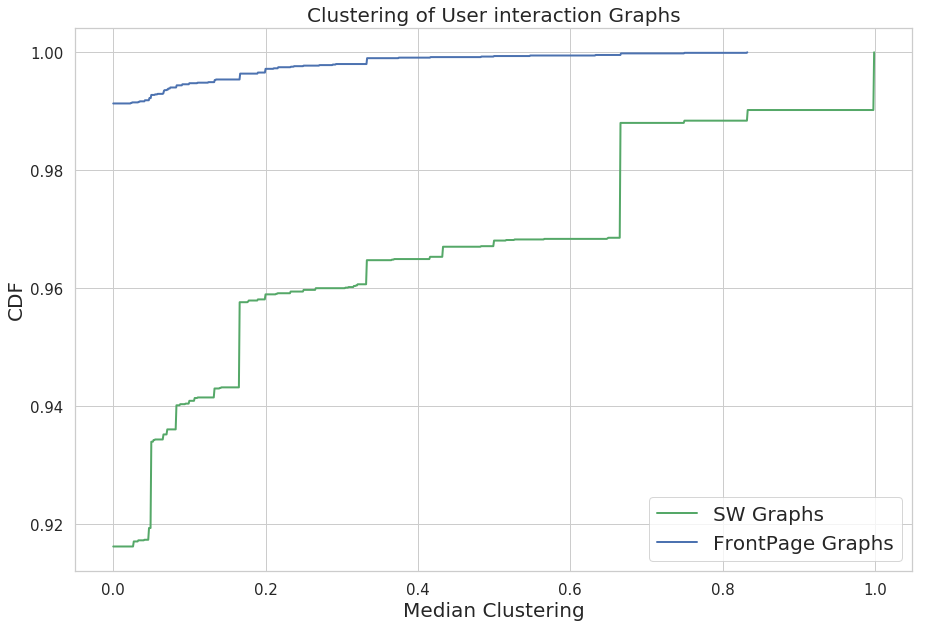

In [58]:
n1 , bins1 , patches1 = plt.hist(SW_medClusterings, 1000, normed=1,histtype='step', cumulative=True,linewidth = 2.0)
n2 , bins2 , patches2 = plt.hist(BL_medClusterings, 1000, normed=1,histtype='step', cumulative=True,linewidth = 2.0)
n3 , bins3 , patches3 = plt.hist(Dep_medClusterings, 1000, normed=1,histtype='step', cumulative=True,linewidth = 2.0)

fig, ax = plt.subplots()
fig.set_size_inches(15, 10)

ax.plot(bins1[:-1], n1, 'g', linewidth=2)
ax.plot(bins2[:-1], n2, 'b', linewidth=2)
# ax.plot(bins3[:-1], n3, 'r--', linewidth=2)

plt.title("Clustering of User interaction Graphs", fontsize = 20)
plt.xlabel("Median Clustering",fontsize = 20)
plt.ylabel("CDF",fontsize = 20)
plt.legend(['SW Graphs','FrontPage Graphs','Depression Graphs'], loc='lower right',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.grid()
plt.show()

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 <a list of 8 Text xticklabel objects>)

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 <a list of 8 Text yticklabel objects>)

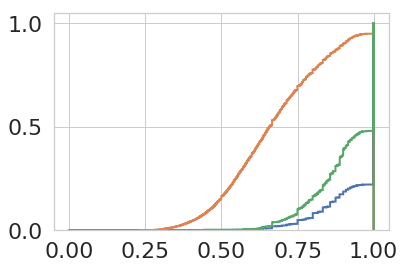

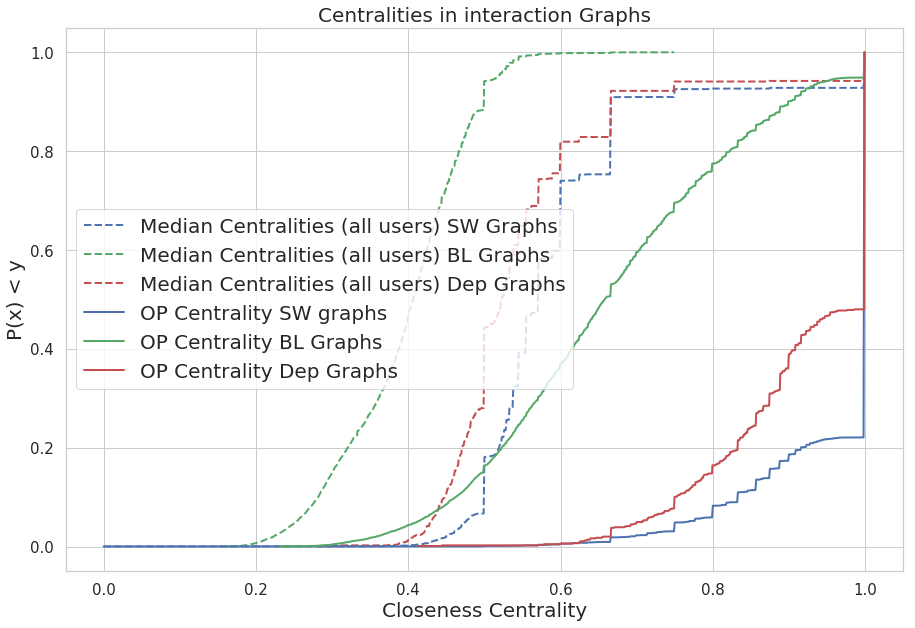

In [59]:
n1 , bins1 , patches1 = plt.hist(SW_opCentralities, 1000, normed=1,histtype='step', cumulative=True,linewidth = 2.0)
n2 , bins2 , patches2 = plt.hist(BL_opCentralities, 1000, normed=1,histtype='step', cumulative=True,linewidth = 2.0)
n3 , bins3 , patches3 = plt.hist(Dep_opCentralities, 1000, normed=1,histtype='step', cumulative=True,linewidth = 2.0)

fig, ax = plt.subplots()
fig.set_size_inches(15, 10)

ax.plot(bins1_all[:-1], n1_all, 'b--', linewidth=2)
ax.plot(bins2_all[:-1], n2_all, 'g--', linewidth=2)
ax.plot(bins3_all[:-1], n3_all, 'r--', linewidth=2)

ax.plot(bins1[:-1], n1, 'b', linewidth=2)
ax.plot(bins2[:-1], n2, 'g', linewidth=2)
ax.plot(bins3[:-1], n3, 'r', linewidth=2)

plt.title("Centralities in interaction Graphs", fontsize = 20)
plt.xlabel("Closeness Centrality",fontsize = 20)
plt.ylabel("P(x) < y",fontsize = 20)
plt.legend(['Median Centralities (all users) SW Graphs','Median Centralities (all users) BL Graphs', 'Median Centralities (all users) Dep Graphs',
            'OP Centrality SW graphs','OP Centrality BL Graphs', 'OP Centrality Dep Graphs'], loc='top left',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.grid()
plt.show()

(array([-0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5]),
 <a list of 7 Text xticklabel objects>)

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 <a list of 8 Text yticklabel objects>)

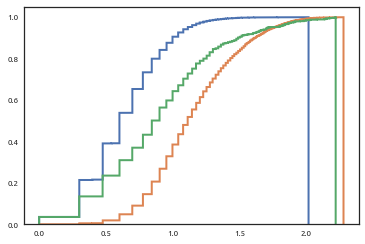

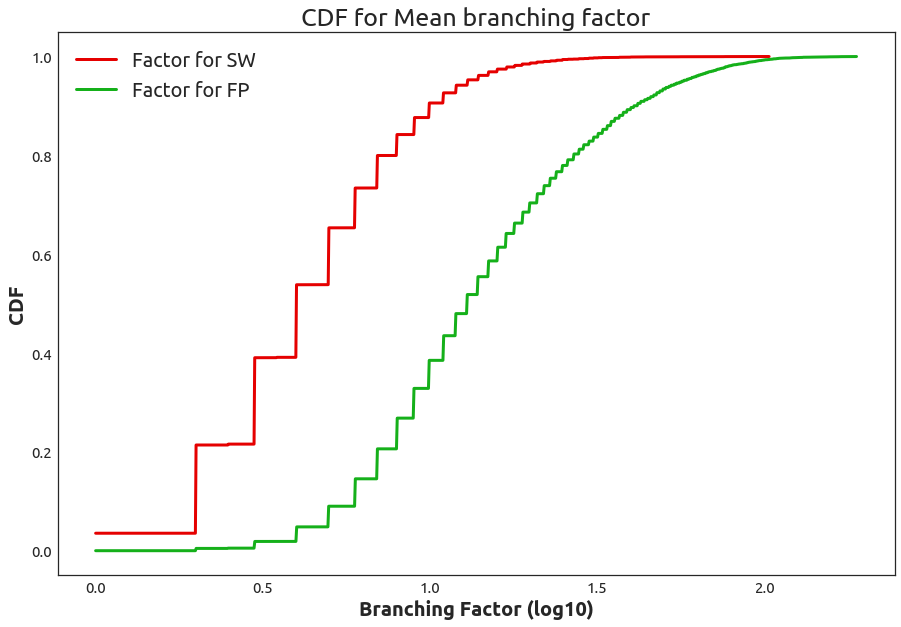

In [264]:
n1 , bins1 , patches1 = plt.hist(np.log10([SW_branching[k][2] for k in SW_branching]), 1000, normed=1,histtype='step', cumulative=True,linewidth = 2.0)
n2 , bins2 , patches2 = plt.hist(np.log10([BL_branching[k][2] for k in BL_branching]), 1000, normed=1,histtype='step', cumulative=True,linewidth = 2.0)
n3 , bins3 , patches3 = plt.hist(np.log10([Dep_branching[k][2] for k in Dep_branching]), 1000, normed=1,histtype='step', cumulative=True,linewidth = 2.0)

fig, ax = plt.subplots()
fig.set_size_inches(15, 10)

ax.plot(bins1[:-1], n1, mcd.XKCD_COLORS['xkcd:red'], linewidth=3)
ax.plot(bins2[:-1], n2, mcd.XKCD_COLORS['xkcd:green'], linewidth=3)
# ax.plot(bins3[:-1], n3, 'r', linewidth=2)

plt.title("CDF for Mean branching factor", fontsize = 25)
plt.xlabel("Branching Factor (log10)",fontsize = 20)
plt.ylabel("CDF",fontsize = 20)
plt.legend(['Factor for SW','Factor for FP'], loc='top left',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.grid()
plt.show()

In [64]:
len(ReplyGraphs_SW), len(ReplyGraphs_BL), len(ReplyGraphs_Dep)

(10527, 11070, 846)

In [65]:
# commonKeys_BL= (set(ReplyGraphs_BL.keys()).intersection(BL_Graphs.keys()))
# len(commonKeys_BL)

In [66]:
# commonKeys_SW_all= (set(ReplyGraphs_SW.keys()).intersection(SW_Graphs.keys()))
# commonKeys_SW = random.sample(commonKeys_SW_all,len(commonKeys_BL))
# len(commonKeys_SW)

In [67]:
commonKeys_BL= [k for k in BL_Graphs if len(BL_Graphs[k].nodes()) >= 3]
print len(commonKeys_BL)

11070


In [68]:
commonKeys_SW= [k for k in SW_Graphs if len(SW_Graphs[k].nodes()) >= 3]
print len(commonKeys_SW)

9857


In [69]:
# |drawReplyGraph(ReplyGraphs_BL[ReplyGraphs_BL.keys()[11]])

In [70]:
ReplyGraphs_BL[ReplyGraphs_BL.keys()[11]].nodes(data=True)

[(u't1_duycd9j',
  {'affects': 25.77,
   'author': u'420throw666',
   'depth': 0,
   'downs': 0,
   'text': 'WHAT IN SWEET BABY RAYS NAME IS THIS FUCKERY',
   'time': 1519811905.0,
   'ups': 6}),
 (u't1_duyeurr',
  {'affects': 25.77,
   'author': u'frumps',
   'depth': 2,
   'downs': 0,
   'text': 'I wouldn\xe2\x80\x99t want to know what\xe2\x80\x99s been done to that tube. ',
   'time': 1519817964.0,
   'ups': 6}),
 (u't1_duybt52',
  {'affects': 25.77,
   'author': u'SullenTerror',
   'depth': 0,
   'downs': 0,
   'text': 'r/blackmagicfuckery',
   'time': 1519810501.0,
   'ups': 18}),
 (u't1_duyff65',
  {'affects': 25.77,
   'author': u'CrunchHardtack',
   'depth': 5,
   'downs': 0,
   'text': "I'm betting there will be no reply or he will have forgotten the name of this extremely memorable book.",
   'time': 1519819132.0,
   'ups': 5}),
 (u't1_duyfb2b',
  {'affects': 25.77,
   'author': u'ShiftyMctwizz',
   'depth': 0,
   'downs': 0,
   'text': 'Misread, expected /u/vernetroyer',
   

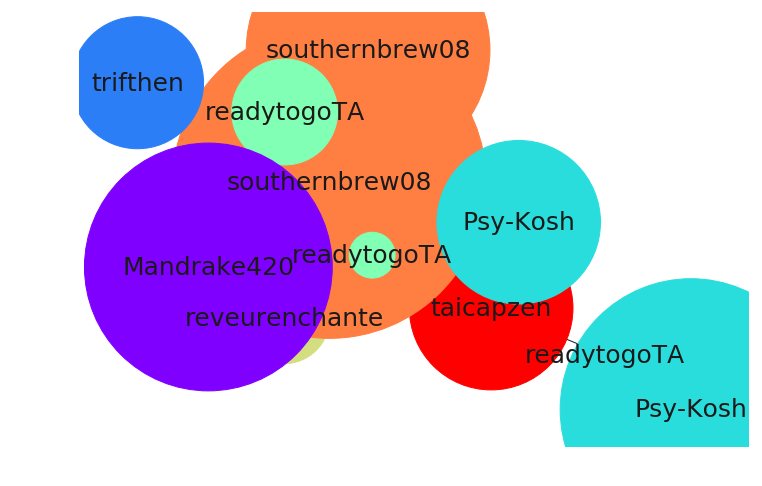

In [71]:
drawReplyGraph(ReplyGraphs_SW[SW_Graphs.keys()[10]])

5


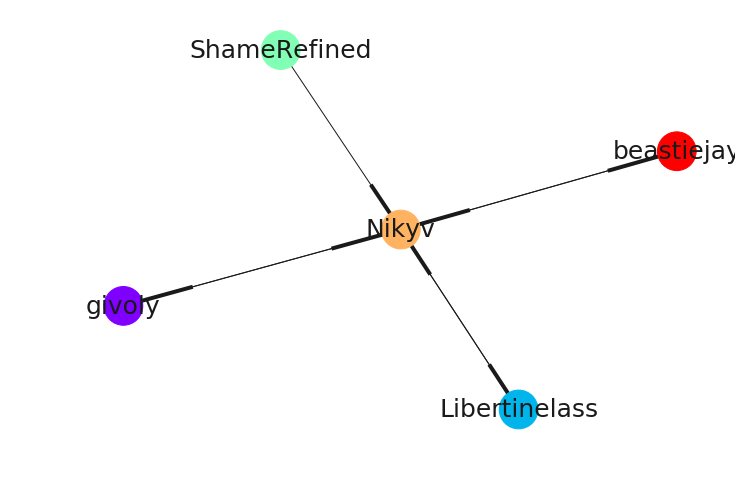

In [72]:
drawUserGraph(SW_Graphs[SW_Graphs.keys()[1011]])

In [73]:
print BL_Graphs[BL_Graphs.keys()[10]].edges(data=True)
print "---------------------------------------------"
print SW_Graphs[SW_Graphs.keys()[10]].edges(data=True)

[(u'bigde32', u'RepostSwat', {'timestamp': 1519772550.0, 'weight': 0.6274394273757935}), (u'bigde32', u'Pikachu1001000', {'timestamp': 1519766258.0, 'weight': -0.01435570120811458}), (u'Darkfire293', u'ConfusedRara', {'timestamp': 1519793099.0, 'weight': 0.30276386737823491}), (u'HeckinGoodDoggo', u'Pikachu1001000', {'timestamp': 1519856774.0, 'weight': 0.063763425871729895}), (u'RepostSwat', u'bigde32', {'timestamp': 1519771831.0, 'weight': 0.7168094396591187}), (u'cawkmonglingwitch', u'Pikachu1001000', {'timestamp': 1519777209.0, 'weight': -0.12951363325119014}), (u'tulpa_man', u'dukethedj', {'timestamp': 1519858881.0, 'weight': 0.1183868452906609}), (u'tulpa_man', u'Transhumaniste', {'timestamp': 1519855385.0, 'weight': 0.21252531111240391}), (u'tulpa_man', u'7aane', {'timestamp': 1520134891.0, 'weight': 0.17292385846376424}), (u'jboogie18', u'Pikachu1001000', {'timestamp': 1519810391.0, 'weight': 0.081425658613443419}), (u'ohlookahipster', u'bigde32', {'timestamp': 1519773449.0, 'w

In [74]:
[k[2]['timestamp'] for k in  BL_Graphs[BL_Graphs.keys()[1]].edges(data=True)]

[1519767002.0,
 1519737618.0,
 1519743103.0,
 1519759467.0,
 1519759268.0,
 1519741464.0,
 1519754961.0,
 1519763424.0,
 1519735576.0,
 1519744893.0,
 1519741112.0,
 1519738654.0,
 1519759406.0,
 1519766754.0,
 1519764482.0,
 1519766286.0,
 1519737984.0]

In [75]:
def getEdgeMetrics(graphs):
    EdgeWeight = []
    aggregateEdgeWeights = []
    varianceEdgeWeights = []
    for k in graphs:
        weights = [k[2]['weight'] for k in  graphs[k].edges(data=True)] 
        aggregateEdgeWeights+=weights
        meanWeight= np.median(weights)
        varWeight = np.var(weights)
        if np.isnan(meanWeight):
            print "Found Nan centrality"
            continue
        else:
            EdgeWeight.append(meanWeight)
        
        if np.isnan(varWeight):
            print "Found Nan Clustering"
            continue
        else:
            varianceEdgeWeights.append(varWeight)
        
    return EdgeWeight , varianceEdgeWeights 
    

In [76]:
SW_edgeWeights , SW_edgeVars = getEdgeMetrics(SW_Graphs)

In [77]:
BL_edgeWeights , BL_edgeVars = getEdgeMetrics(BL_Graphs)

In [78]:
Dep_edgeWeights , Dep_edgeVars = getEdgeMetrics(Dep_Graphs)

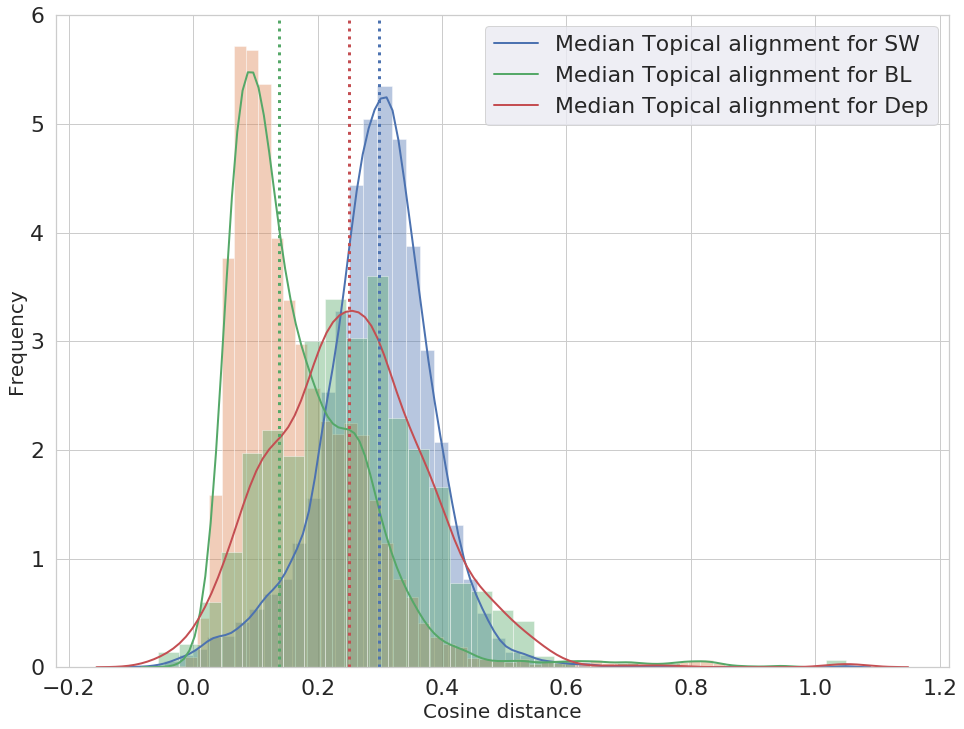

In [79]:
sns.set_style("whitegrid")
fig, ax = plt.subplots()

fig.set_size_inches(16,12)
sns.set(font_scale=2) 
sns.distplot(SW_edgeWeights,kde_kws={"color": "b", "lw": 2, "label": "Median Topical alignment for SW"})
sns.distplot(BL_edgeWeights,kde_kws={"color": "g", "lw": 2, "label": "Median Topical alignment for BL"})
sns.distplot(Dep_edgeWeights,kde_kws={"color": "r", "lw": 2, "label": "Median Topical alignment for Dep"})
ax.axvline(x=np.median(SW_edgeWeights), ymin=0, ymax=1, linewidth=3, color = 'b', linestyle='dotted')
ax.axvline(x=np.median(BL_edgeWeights), ymin=0, ymax=1, linewidth=3, color = 'g', linestyle='dotted')
ax.axvline(x=np.median(Dep_edgeWeights), ymin=0, ymax=1, linewidth=3, color = 'r', linestyle='dotted')
plt.xlabel("Cosine distance" , fontsize = 20)
plt.ylabel("Frequency" , fontsize = 20 )

In [85]:
sns.set_style('whitegrid')

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 <a list of 8 Text xticklabel objects>)

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 <a list of 8 Text yticklabel objects>)

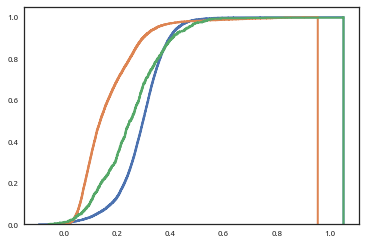

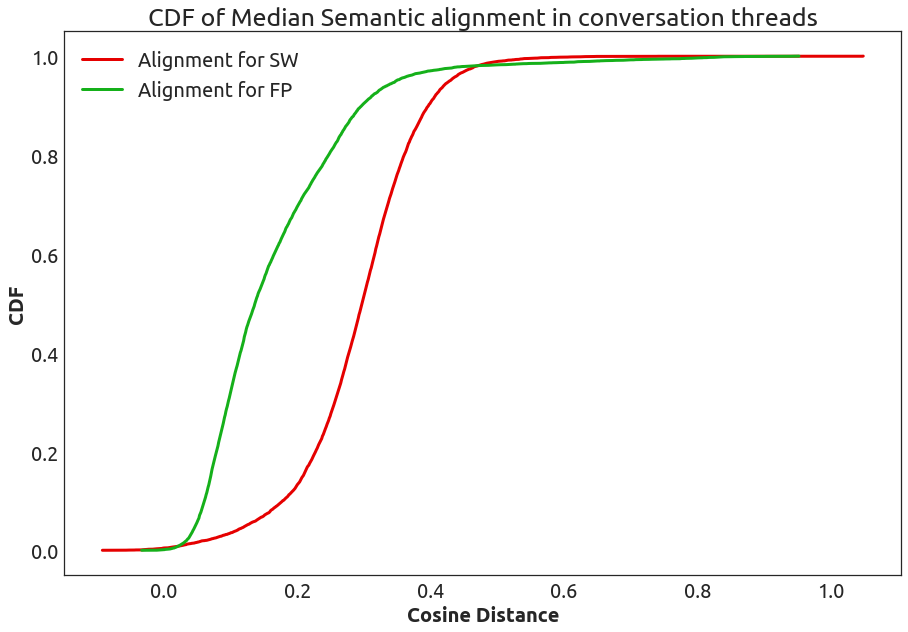

In [265]:
n1 , bins1 , patches1 = plt.hist(SW_edgeWeights, 1000, normed=1,histtype='step', cumulative=True,linewidth = 2.0)
n2 , bins2 , patches2 = plt.hist(BL_edgeWeights, 1000, normed=1,histtype='step', cumulative=True,linewidth = 2.0)
n3 , bins3 , patches3 = plt.hist(Dep_edgeWeights, 1000, normed=1,histtype='step', cumulative=True,linewidth = 2.0)

fig, ax = plt.subplots()
fig.set_size_inches(15, 10)

ax.plot(bins1[:-1], n1, mcd.XKCD_COLORS['xkcd:red'], linewidth=3)
ax.plot(bins2[:-1], n2, mcd.XKCD_COLORS['xkcd:green'], linewidth=3)
# ax.plot(bins3[:-1], n3, 'r', linewidth=2)

plt.title("CDF of Median Semantic alignment in conversation threads", fontsize = 25)
plt.xlabel("Cosine Distance",fontsize = 20)
plt.ylabel("CDF",fontsize = 20)
plt.legend(['Alignment for SW','Alignment for FP '], loc='top left',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# plt.grid()
plt.show()

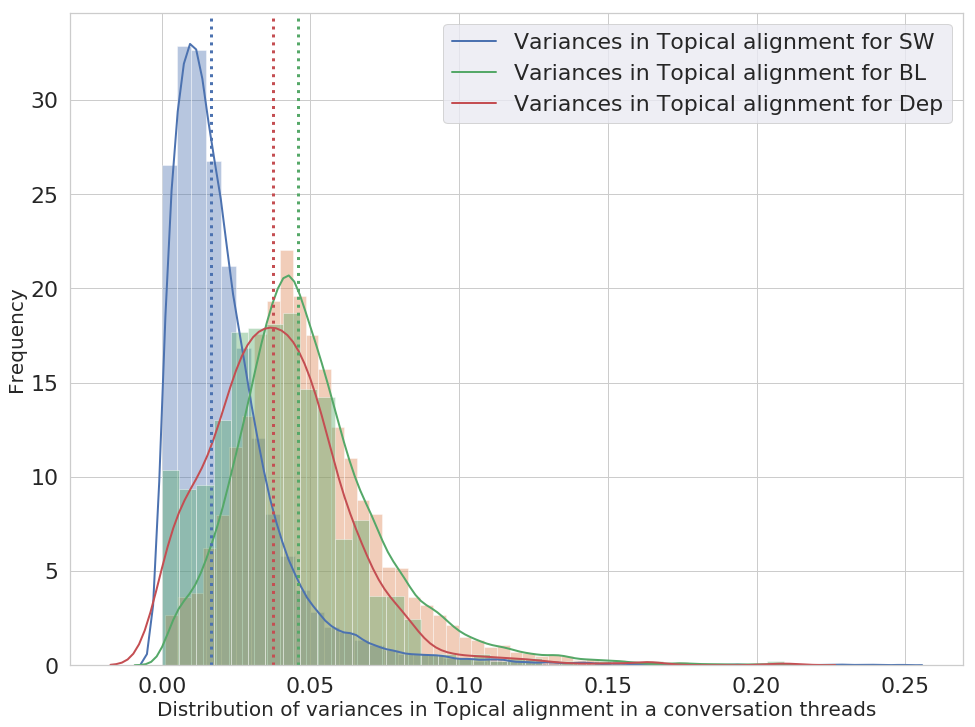

In [87]:
fig, ax = plt.subplots()
fig.set_size_inches(16,12)
sns.set(font_scale=2) 
sns.distplot(SW_edgeVars,kde_kws={"color": "b", "lw": 2, "label": "Variances in Topical alignment for SW"})
sns.distplot(BL_edgeVars,kde_kws={"color": "g", "lw": 2, "label": "Variances in Topical alignment for BL"})
sns.distplot(Dep_edgeVars,kde_kws={"color": "r", "lw": 2, "label": "Variances in Topical alignment for Dep"})
ax.axvline(x=np.median(SW_edgeVars), ymin=0, ymax=1, linewidth=3, color = 'b', linestyle='dotted')
ax.axvline(x=np.median(BL_edgeVars), ymin=0, ymax=1, linewidth=3, color = 'g', linestyle='dotted')
ax.axvline(x=np.median(Dep_edgeVars), ymin=0, ymax=1, linewidth=3, color = 'r', linestyle='dotted')
plt.xlabel("Distribution of variances in Topical alignment in a conversation threads" , fontsize = 20)
plt.ylabel("Frequency" , fontsize = 20 )

In [88]:
ReplyGraphs_SW[ReplyGraphs_SW.keys()[101]].nodes(data=True)

[(u't1_c6xmw8s',
  {'affects': 1.0,
   'author': u'bluegerm',
   'depth': 2,
   'downs': 0,
   'text': 'why do you want to run away, are you having problems with your family?',
   'time': 1352263881.0,
   'ups': 2}),
 (u't1_c6xqd6v',
  {'affects': 79.41,
   'author': u'bluegerm',
   'depth': 4,
   'downs': 0,
   'text': "It sounds like you want to escape because you think it's an easy way out of your problems.  It isn't an easy way out, it's just a fantasy.  While you continue the fantasy you'll continue to avoid dealing with the problems with your life and let them build.  One day they may become big enough to make you feel you have no choice.  The real way out is to start facing your problems one by one and begin dealing with them, finding solutions.  You can do it.  You'll grow and change.  Accept the challenge of life and you'll begin to enjoy it.",
   'time': 1352286834.0,
   'ups': 1}),
 (u't1_c6xkqq2',
  {'affects': 25.77,
   'author': u'Kolkhoz',
   'depth': 0,
   'downs': 0,
 

In [89]:
# drawReplyGraph(ReplyGraphs_SW[ReplyGraphs_SW.keys()[101]])

In [90]:
class Tree:
    nxGraph = None
    path = []
    nodes = {}
    visited = []
    def __init__(self,G):
        self.nxGraph = G
        nodes = G.nodes(data=True)
        for n in nodes:
            self.nodes[n[0]] = n[1]
        
    def parseTree(self,node):
        if node != None:
            print self.nodes[node]
            self.visited.append(node)
            inEdges = self.nxGraph.in_edges(node , data=True)
            for k in inEdges:
                if k not in self.visited:
                    print k
                    self.parseTree(k[0])        
    
    def printPath(self):
        print self.path
    

def findLongChains(replyGraphs):
    chains = {}
    for k in replyGraphs:
        print "helllo"
        
        

In [91]:
BL_Graphs[BL_Graphs.keys()[160]].edges(data=True)

[(u'sketh_uwu',
  u'icouldberaff',
  {'timestamp': 1519862865.0, 'weight': 0.03806175217032437}),
 (u'icouldberaff',
  u'icouldberaff',
  {'timestamp': 1519858540.0, 'weight': -0.064774271845817522}),
 (u'icouldberaff',
  u'Unique_username91620',
  {'timestamp': 1519867871.0, 'weight': 0.77733074426651005}),
 (u'icouldberaff',
  u'JaxonH',
  {'timestamp': 1519864004.0, 'weight': 0.54900752305984502}),
 (u'icouldberaff',
  u'sketh_uwu',
  {'timestamp': 1519862894.0, 'weight': 0.51499142050743107}),
 (u'PerswAsian',
  u'icouldberaff',
  {'timestamp': 1519876445.0, 'weight': 0.2786637127399445}),
 (u'running_fridge',
  u'InuKaT',
  {'timestamp': 1519875382.0, 'weight': 0.32444878220558171}),
 (u'InuKaT',
  u'icouldberaff',
  {'timestamp': 1519873022.0, 'weight': 0.16962066590785985}),
 (u'InuKaT',
  u'Unique_username91620',
  {'timestamp': 1519884637.0, 'weight': 0.26614354848861699}),
 (u'InuKaT',
  u'running_fridge',
  {'timestamp': 1519876277.0, 'weight': 0.33201994299888615}),
 (u'pla

In [92]:
## this code is extension of Bataglij work on subquadratic triadic census. I am adding a feature to return the nodes in a triad along with vertex tagging.

# triads.py - functions for analyzing triads of a graph
#
# Copyright 2015 NetworkX developers.
# Copyright 2011 Reya Group <http://www.reyagroup.com>
# Copyright 2011 Alex Levenson <alex@isnotinvain.com>
# Copyright 2011 Diederik van Liere <diederik.vanliere@rotman.utoronto.ca>
#
# This file is part of NetworkX.
#
# NetworkX is distributed under a BSD license; see LICENSE.txt for more
# information.
"""Functions for analyzing triads of a graph."""
from __future__ import division

import networkx as nx
import operator

__author__ = '\n'.join(['Alex Levenson (alex@isnontinvain.com)',
                        'Diederik van Liere (diederik.vanliere@rotman.utoronto.ca)','Sagar Joglekar (sagar.joglekar@kcl.ac.uk'])

__all__ = ['my_triadic_census']

#: The names of each type of triad.
TRIAD_NAMES = ('003', '012', '102', '021D', '021U', '021C', '111D', '111U',
               '030T', '030C', '201', '120D', '120U', '120C', '210', '300')

#: The integer codes representing each type of triad.
#:
#: Triads that are the same up to symmetry have the same code.
TRICODES = (1, 2, 2, 3, 2, 4, 6, 8, 2, 6, 5, 7, 3, 8, 7, 11, 2, 6, 4, 8, 5, 9,
            9, 13, 6, 10, 9, 14, 7, 14, 12, 15, 2, 5, 6, 7, 6, 9, 10, 14, 4, 9,
            9, 12, 8, 13, 14, 15, 3, 7, 8, 11, 7, 12, 14, 15, 8, 14, 13, 15,
            11, 15, 15, 16)

#: A dictionary mapping triad code to triad name.
TRICODE_TO_NAME = {i: TRIAD_NAMES[code - 1] for i, code in enumerate(TRICODES)}


def triad_graphs():
    """Returns a dictionary mapping triad name to triad graph."""

    def abc_graph():
        """Returns a directed graph on three nodes, named ``'a'``, ``'b'``, and
        ``'c'``.

        """
        G = nx.DiGraph()
        G.add_nodes_from('abc')
        return G

    tg = {name: abc_graph() for name in TRIAD_NAMES}
    tg['012'].add_edges_from([('a', 'b')])
    tg['102'].add_edges_from([('a', 'b'), ('b', 'a')])
    tg['102'].add_edges_from([('a', 'b'), ('b', 'a')])
    tg['021D'].add_edges_from([('b', 'a'), ('b', 'c')])
    tg['021U'].add_edges_from([('a', 'b'), ('c', 'b')])
    tg['021C'].add_edges_from([('a', 'b'), ('b', 'c')])
    tg['111D'].add_edges_from([('a', 'c'), ('c', 'a'), ('b', 'c')])
    tg['111U'].add_edges_from([('a', 'c'), ('c', 'a'), ('c', 'b')])
    tg['030T'].add_edges_from([('a', 'b'), ('c', 'b'), ('a', 'c')])
    tg['030C'].add_edges_from([('b', 'a'), ('c', 'b'), ('a', 'c')])
    tg['201'].add_edges_from([('a', 'b'), ('b', 'a'), ('a', 'c'), ('c', 'a')])
    tg['120D'].add_edges_from([('b', 'c'), ('b', 'a'), ('a', 'c'), ('c', 'a')])
    tg['120C'].add_edges_from([('a', 'b'), ('b', 'c'), ('a', 'c'), ('c', 'a')])
    tg['120U'].add_edges_from([('a', 'b'), ('c', 'b'), ('a', 'c'), ('c', 'a')])
    tg['210'].add_edges_from([('a', 'b'), ('b', 'c'), ('c', 'b'), ('a', 'c'),
                              ('c', 'a')])
    tg['300'].add_edges_from([('a', 'b'), ('b', 'a'), ('b', 'c'), ('c', 'b'),
                              ('a', 'c'), ('c', 'a')])
    return tg


def _tricode(G, v, u, w):
    """Returns the integer code of the given triad.

    This is some fancy magic that comes from Batagelj and Mrvar's paper. It
    treats each edge joining a pair of ``v``, ``u``, and ``w`` as a bit in
    the binary representation of an integer.

    """
    combos = ((v, u, 1), (u, v, 2), (v, w, 4), (w, v, 8), (u, w, 16),
              (w, u, 32))
    return sum(x for u, v, x in combos if v in G[u])


def my_triadic_census(G):
    """Determines the triadic census of a directed graph.

    The triadic census is a count of how many of the 16 possible types of
    triads are present in a directed graph.

    Parameters
    ----------
    G : digraph
       A NetworkX DiGraph

    Returns
    -------
    census : dict
       Dictionary with triad names as keys and number of occurrences as values.

    Notes
    -----
    This algorithm has complexity `O(m)` where `m` is the number of edges in
    the graph.

    References
    ----------
    .. [1] Vladimir Batagelj and Andrej Mrvar, A subquadratic triad census
        algorithm for large sparse networks with small maximum degree,
        University of Ljubljana,
        http://vlado.fmf.uni-lj.si/pub/networks/doc/triads/triads.pdf

    """
    if not G.is_directed():
        raise nx.NetworkXError('Not defined for undirected graphs.')

    # Initialize the count for each triad to be zero.
    census = {name: 0 for name in TRIAD_NAMES}
    census_nodes = {name: [] for name in TRIAD_NAMES}
    taggedNodes = []
    n = len(G)
    # m = dict(zip(G, range(n)))
    m = {v: i for i, v in enumerate(G)}
    for v in G:
        vnbrs = set(G.pred[v]) | set(G.succ[v])
        for u in vnbrs:
            if m[u] <= m[v]:
                continue
            neighbors = (vnbrs | set(G.succ[u]) | set(G.pred[u])) - {u, v}
            compliment = [node for node in G.nodes() if node not in neighbors]
            # Calculate dyadic triads instead of counting them.
            # This is a problem for registering node members of this motif. This method of counting disallows recording the exact nodes that are part of the motif
            if v in G[u] and u in G[v]:
                census['102'] += n - len(neighbors) - 2
                for node in compliment:
                    if node not in [u,v]:
                        census_nodes['102'].append([u,v,node])
            else:
                census['012'] += n - len(neighbors) - 2
                for node in compliment:
                    if node not in [u,v]:
                        census_nodes['012'].append([u,v,node])
                    
            # Count connected triads.
            for w in neighbors:
                if m[u] < m[w] or (m[v] < m[w] and m[w] < m[u]
                                   and v not in G.pred[w]
                                   and v not in G.succ[w]):
                    code = _tricode(G, v, u, w)
                    census[TRICODE_TO_NAME[code]] += 1
                    census_nodes[TRICODE_TO_NAME[code]].append([v,u,w])

    # null triads = total number of possible triads - all found triads
    #
    # Use integer division here, since we know this formula guarantees an
    # integral value.
    census['003'] = ((n * (n - 1) * (n - 2)) // 6) - sum(census.values())
#     print("Calculation Done!!")
    return census, census_nodes




def getApexNode_201_111D_021U_021D_021C_111U(triad, G):
#     print triad
    degs = [G.degree(i) for i in triad]
    return triad[np.argmax(degs)]


def getThreadLifeTimes(graphs):
    lifetimes = []
    for g in graphs:
        G = graphs[g]
        ts =  nx.get_edge_attributes(G,'timestamp').values()
        ts.sort()
        lifetimes.append(float(ts[-1]) - float(ts[0]) + 1)
    return lifetimes 


def getMotifAges(G, MotifArray):
    ts =  nx.get_edge_attributes(G,'timestamp').values()
    ts.sort()
    ages = []
    for triad in MotifArray:
        triadAge = []
        for node in triad:
            edges = G[node]
            for n in triad:
                if n in edges:
                    age = (float(edges[n]['timestamp']) - float(ts[0]))/(float(ts[-1]) - float(ts[0]))
                    triadAge.append(age)
        ages.append(np.max(triadAge))
    return ages

def findEdgeOrder(edge,sortedEdges):
    count = 0
    for k in sortedEdges:
        if edge == k:
            return float(count)/float(len(sortedEdges))
        count +=1
    return None
            
        
def getMotifOrder(G, MotifArray):
    ts =  nx.get_edge_attributes(G,'timestamp')
    sorted_ts = sorted(ts.items(), key=operator.itemgetter(1))
    ages = []
    for triad in MotifArray:
        triadAge = []
        for node in triad:
            edges = G[node]
            for n in triad:
                if n in edges:
#                     print ((node,n),edges[n]['timestamp'])
                    order = findEdgeOrder(((node,n),edges[n]['timestamp']),sorted_ts)                    
                    triadAge.append(order)
        ages.append(np.max(triadAge))
    return ages

#--------------------------------------------------------------------------------------------------------------------
# Motif variant counters
#--------------------------------------------------------------------------------------------------------------------


def test111D(graph, op):
    nodes = graph.nodes()
    indegs = graph.in_degree()
    outdegs = graph.out_degree()
    if op in nodes:
        if outdegs[op] == 1 and indegs[op] == 0:
            return 0
        elif indegs[op] == 2 and outdegs[op] == 1:
            return 1
        else:
            return 2
    else:
#         print "Op not in the motif, continuing"
        return 3
    
def test201(graph, op):
    nodes = graph.nodes()
    indegs = graph.in_degree()
    outdegs = graph.out_degree()
    if op in nodes:
        if indegs[op] == 2 and outdegs[op] == 2:
            return 1
        else:
            return 0
    else:
#         print "Op not in the motif, continuing"
        return 3
    
def test021U(graph, op):
    nodes = graph.nodes()
    indegs = graph.in_degree()
    outdegs = graph.out_degree()
    if op in nodes:
        if indegs[op] == 2:
            return 1
        else:
            return 0
    else:
#         print "Op not in the motif, continuing"
        return 3

def test012(graph, op):
    nodes = graph.nodes()
    indegs = graph.in_degree()
    outdegs = graph.out_degree()
    if op in nodes:
        if outdegs[op] == 1 and indegs[op] == 0:
#             print "type a"
            return 0
        elif indegs[op] == 1 and outdegs[op] == 0:
#             print "type b"
            return 1
        else:
#             print "type c"
            return 2
    else:
#         print "Op not in the motif, continuing"
        return 3
    
def test102(graph, op):
    nodes = graph.nodes()
    indegs = graph.in_degree()
    outdegs = graph.out_degree()
    if op in nodes:
        if outdegs[op] == 0 and indegs[op] == 0:
            return 0
        else:
            return 1
    else:
#         print "Op not in the motif, continuing"
        return 3
        
def test021D(graph, op):
    nodes = graph.nodes()
    indegs = graph.in_degree()
    outdegs = graph.out_degree()
    if op in nodes:
        if outdegs[op] == 2 and indegs[op] == 0:
            return 1
        else:
            return 0
    else:
#         print "Op not in the motif, continuing"
        return 3

    
def test021C(graph, op):
    nodes = graph.nodes()
    indegs = graph.in_degree()
    outdegs = graph.out_degree()
    if op in nodes:
        if outdegs[op] == 1 and indegs[op] == 0:
            return 0
        elif indegs[op] == 1 and outdegs[op] == 1:
            return 1
        else:
            return 2
    else:
#         print "Op not in the motif, continuing"
        return 3
    
def test111U(graph, op):
    nodes = graph.nodes()
    indegs = graph.in_degree()
    outdegs = graph.out_degree()
    if op in nodes:
        if outdegs[op] == 0 and indegs[op] == 1:
            return 0
        elif indegs[op] == 1 and outdegs[op] == 2:
            return 1
        else:
            return 2
    else:
#         print "Op not in the motif, continuing"
        return 3
    
    
def test030T(graph, op):
    nodes = graph.nodes()
    indegs = graph.in_degree()
    outdegs = graph.out_degree()
    if op in nodes:
        if outdegs[op] == 2 and indegs[op] == 0:
            return 0
        elif indegs[op] == 2 and outdegs[op] == 0:
            return 1
        else:
            return 2
    else:
#         print "Op not in the motif, continuing"
        return 3
    

def test120D(graph, op):
    nodes = graph.nodes()
    indegs = graph.in_degree()
    outdegs = graph.out_degree()
    if op in nodes:
        if outdegs[op] == 2 and indegs[op] == 0:
            return 1
        else:
            return 0
    else:
#         print "Op not in the motif, continuing"
        return 3
    

def test120U(graph, op):
    nodes = graph.nodes()
    indegs = graph.in_degree()
    outdegs = graph.out_degree()
    if op in nodes:
        if outdegs[op] == 0 and indegs[op] == 2:
            return 1
        else:
            return 0
    else:
#         print "Op not in the motif, continuing"
        return 3
    

def test120C(graph, op):
    nodes = graph.nodes()
    indegs = graph.in_degree()
    outdegs = graph.out_degree()
    if op in nodes:
        if outdegs[op] == 2 and indegs[op] == 1:
            return 0
        elif indegs[op] == 1 and outdegs[op] == 1:
            return 1
        else:
            return 2
    else:
#         print "Op not in the motif, continuing"
        return 3
    
def test210(graph, op):
    nodes = graph.nodes()
    indegs = graph.in_degree()
    outdegs = graph.out_degree()
    if op in nodes:
        if outdegs[op] == 2 and indegs[op] == 1:
            return 0
        elif indegs[op] == 2 and outdegs[op] == 1:
            return 1
        else:
            return 2
    else:
#         print "Op not in the motif, continuing"
        return 3
    

def getUnrolledMotifs(G , triads , motifString, opName):
    triadList = triads[motifString]
    Unrolled_Census = [0 , 0 , 0 , 0]
    if motifString in ['003' , '030C' , '300']:
#         print "Motif is perfectly symmetric"
        Unrolled_Census = [len(triadList) , 0 , 0 , 0]
        return Unrolled_Census
    else:
        for nodes in triadList:
            triad_graph = G.subgraph(nodes)
            if motifString == '012':
                mo_type = test012(triad_graph,opName)
                
            elif motifString == '102':
                mo_type = test102(triad_graph,opName)
            
            elif motifString == '021D':
                mo_type = test021D(triad_graph,opName)
            
            elif motifString == '021U':
                mo_type = test021U(triad_graph,opName) 
            
            elif motifString == '021C':
                mo_type = test021C(triad_graph,opName)
                     
            elif motifString == '111D':
                mo_type = test111D(triad_graph,opName)
            
            elif motifString == '111U':
                mo_type = test111U(triad_graph,opName)
            
            elif motifString == '030T':
                mo_type = test030T(triad_graph,opName)
            
            elif motifString == '201':
                mo_type = test201(triad_graph,opName)
            
            elif motifString == '120D':
                mo_type = test120D(triad_graph,opName)

            elif motifString == '120U':
                mo_type = test120U(triad_graph,opName)
            
            elif motifString == '120C':
                mo_type = test120C(triad_graph,opName)
            
            elif motifString == '210':
                mo_type = test210(triad_graph,opName)
            
            else:
                print "Something is not right!!, received motif string %s"%motifString
                return Unrolled_Census
                
            Unrolled_Census[mo_type]+=1

        return Unrolled_Census
            

'Functions for analyzing triads of a graph.'

In [93]:
# sys.path.append("../Code/")
# import myTriadicCensus
G = BL_Graphs[BL_Graphs.keys()[160]]


22


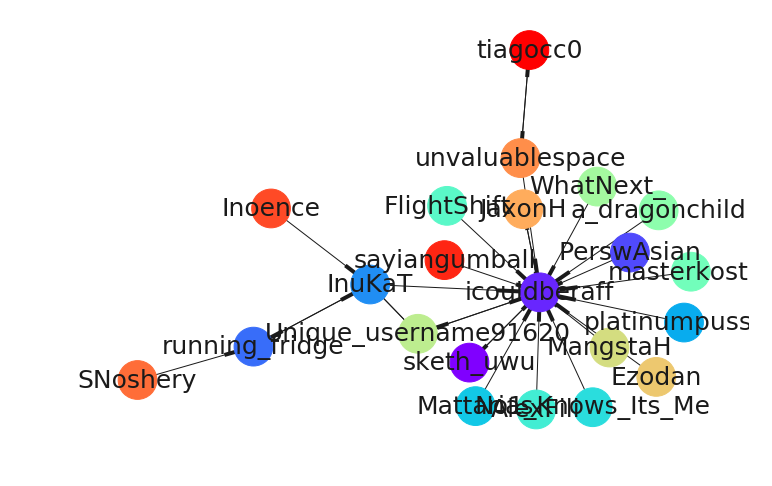

In [94]:
drawUserGraph(BL_Graphs[BL_Graphs.keys()[160]])

In [95]:
ts =  nx.get_edge_attributes(G,'timestamp')
sortedTs = sorted(ts, key=lambda X: ts[X])
import operator
sorted_x = sorted(ts.items(), key=operator.itemgetter(1))
print sorted_x[0][1]

1519858540.0


In [96]:
G['Unique_username91620']

{u'InuKaT': {'timestamp': 1519883322.0, 'weight': 0.377931821346283},
 u'icouldberaff': {'timestamp': 1519867750.0, 'weight': 0.12245265692472462}}

In [97]:
a =  nx.get_edge_attributes(G,'timestamp').values()
a.sort()
print a[-1] - a[0]

89758.0


In [98]:
keys, triads = my_triadic_census(G)
print keys
unrolledCensus = getUnrolledMotifs(G, triads , '111D' , FP_OpAuthors[BL_Graphs.keys()[160]])
print unrolledCensus

{'201': 4, '021C': 1, '021D': 0, '210': 1, '120U': 0, '030C': 0, '003': 1244, '300': 0, '012': 89, '021U': 91, '120D': 0, '102': 64, '111U': 2, '030T': 0, '120C': 0, '111D': 44}
[0, 0, 41, 3]


In [99]:
print getMotifAges(G,triads['021U'])

[0.56420597606898548, 0.56420597606898548, 0.56420597606898548, 0.56420597606898548, 0.56420597606898548, 0.588437799416208, 0.52637090844270151, 0.16069876779785647, 0.16069876779785647, 0.16069876779785647, 0.588437799416208, 0.52637090844270151, 0.52637090844270151, 0.52637090844270151, 0.588437799416208, 0.56420597606898548, 0.19948082622161814, 0.365438178212527, 0.19948082622161814, 0.52637090844270151, 0.19948082622161814, 0.19948082622161814, 0.19948082622161814, 0.281334254328305, 0.19948082622161814, 1.0, 0.19948082622161814, 0.588437799416208, 0.089618752646003705, 0.11934312261859667, 0.588437799416208, 0.588437799416208, 0.588437799416208, 0.56420597606898548, 0.19562601662247375, 0.16134494975378239, 0.52637090844270151, 0.16134494975378239, 0.16134494975378239, 0.365438178212527, 0.16134494975378239, 0.281334254328305, 1.0, 0.16134494975378239, 0.588437799416208, 0.56420597606898548, 0.19562601662247375, 0.365438178212527, 0.16069876779785647, 0.52637090844270151, 0.0931

In [100]:
print getMotifOrder(G,triads['021U'])

[0.7931034482758621, 0.7931034482758621, 0.7931034482758621, 0.7931034482758621, 0.7931034482758621, 0.82758620689655171, 0.75862068965517238, 0.37931034482758619, 0.37931034482758619, 0.37931034482758619, 0.82758620689655171, 0.75862068965517238, 0.75862068965517238, 0.75862068965517238, 0.82758620689655171, 0.7931034482758621, 0.55172413793103448, 0.72413793103448276, 0.55172413793103448, 0.75862068965517238, 0.55172413793103448, 0.55172413793103448, 0.55172413793103448, 0.65517241379310343, 0.55172413793103448, 0.96551724137931039, 0.55172413793103448, 0.82758620689655171, 0.20689655172413793, 0.34482758620689657, 0.82758620689655171, 0.82758620689655171, 0.82758620689655171, 0.7931034482758621, 0.48275862068965519, 0.41379310344827586, 0.75862068965517238, 0.41379310344827586, 0.41379310344827586, 0.72413793103448276, 0.41379310344827586, 0.65517241379310343, 0.96551724137931039, 0.41379310344827586, 0.82758620689655171, 0.7931034482758621, 0.48275862068965519, 0.72413793103448276,

In [101]:
def doUnrolledAnalysis(Graphs, triadList,opList):
    triad_names = ['003', '012', '102', '021D', '021U', '021C', '111D', '111U','030T', '030C', '201', '120D', '120U', '120C', '210', '300']
    unrolledMotifs = {}
    for k in triad_names:
        unrolledMotifs[k] = [[0], [0] ,[0] ,[0]]
    
    for g in Graphs: 
        try:
            G = Graphs[g]
            triads = triadList[g]
            op = opList[g]
        except:
            continue
            
        for k in triads:
            unrolled_motif_count = getUnrolledMotifs(G, triads , k ,op)
            for i in range(4):
                unrolledMotifs[k][i].append(unrolled_motif_count[i])
    return unrolledMotifs

def getMotifLifeTimes(Graphs, allTriadNodes):
    lifetimeArray= { '111D' : [] , '201' : [] , '021U' : [] , '021D' : [] , '021C' : [] , '111U' : [] }
    for k in allTriadNodes:
        if len(Graphs[k].nodes()) < 35:
            for m in lifetimeArray.keys():
    #             lifeTimes = getMotifOrder(Graphs[k], allTriadNodes[k][m])
                lifeTimes = getMotifAges(Graphs[k], allTriadNodes[k][m])
                lifetimeArray[m]+=lifeTimes
    return lifetimeArray

def getApexNodeStat(Graphs , allTriadNodes , opAuthors):
    apexNodeArray= { '111D' : [] , '201' : [] , '021U' : [] , '021D' : [] , '021C' : [] , '111U' : [] }
    for k in allTriadNodes:
        if k in opAuthors:
            for m in apexNodeArray.keys():
                count = 0.0
                frac = 0.0
                for triad in allTriadNodes[k][m]:
                    apexNode = getApexNode_201_111D_021U_021D_021C_111U(triad,Graphs[k])
                    if apexNode == opAuthors[k]:
                        count+=1
                if len(allTriadNodes[k][m]) > 0:
                    frac = count/float(len(allTriadNodes[k][m]))
                apexNodeArray[m].append(frac)
    return apexNodeArray

def getTriadicCensus(graphs , keys=None):
    triadicCensus = {}
    triadNodes = {}
    if not keys:
        print "No selector dictionary passed"
        keys = graphs.keys()

    for g in keys:
        census, triads = my_triadic_census(graphs[g])
#         denom = len(graphs[g].nodes())+1
        
        triadicCensus[g] = {}
        triadicCensus[g] = census
        triadNodes[g] = {}
        triadNodes[g] = triads
#         for k in triadicCensus[g]:
#             triadicCensus[g][k]= float(triadicCensus[g][k])/float(denom)
    return triadicCensus , triadNodes


def getUnrolledTriadicCensus(graphs , opDict, keys=None):
    triadicCensus = {}
    if not keys:
        print "No selector dictionary passed"
        keys = graphs.keys()

    for g in keys:
        census, triads = my_triadic_census(graphs[g])
        unrolledCensusdDict = {}
        for k in census:
            unrolledCensus = getUnrolledMotifs(graphs[g], triads , k , opDict[g] )
            unrolledCensusdDict[k] = unrolledCensus
#         denom = len(graphs[g].nodes())+1
        
        triadicCensus[g] = {}
        triadicCensus[g] = unrolledCensusdDict
    return triadicCensus 
    

In [102]:
len(commonKeys_SW) , len(commonKeys_BL)

(9857, 11070)

In [103]:

triads_SW , triadNodes_SW = getTriadicCensus(SW_Graphs, commonKeys_SW)

In [104]:
triads_SW_unroll = getUnrolledTriadicCensus(SW_Graphs, SW_OpAuthors, commonKeys_SW)

In [105]:
triads_SW_unroll

{'vj5co': {'003': [0, 0, 0, 0],
  '012': [0, 0, 0, 0],
  '021C': [0, 0, 0, 0],
  '021D': [0, 0, 0, 0],
  '021U': [0, 0, 0, 0],
  '030C': [0, 0, 0, 0],
  '030T': [0, 0, 0, 0],
  '102': [0, 0, 0, 0],
  '111D': [0, 0, 3, 0],
  '111U': [0, 0, 0, 0],
  '120C': [0, 0, 0, 0],
  '120D': [0, 0, 0, 0],
  '120U': [0, 0, 0, 0],
  '201': [3, 0, 0, 0],
  '210': [0, 0, 0, 0],
  '300': [0, 0, 0, 0]},
 '1uv2vj': {'003': [0, 0, 0, 0],
  '012': [0, 1, 0, 2],
  '021C': [0, 0, 0, 0],
  '021D': [0, 0, 0, 0],
  '021U': [0, 0, 0, 0],
  '030C': [0, 0, 0, 0],
  '030T': [0, 0, 0, 0],
  '102': [0, 1, 0, 0],
  '111D': [0, 2, 1, 0],
  '111U': [0, 0, 0, 0],
  '120C': [0, 0, 0, 0],
  '120D': [0, 0, 0, 0],
  '120U': [0, 0, 0, 0],
  '201': [0, 1, 0, 0],
  '210': [0, 0, 0, 0],
  '300': [0, 0, 0, 0]},
 'fjatc': {'003': [0, 0, 0, 0],
  '012': [0, 0, 0, 0],
  '021C': [0, 0, 0, 0],
  '021D': [0, 0, 0, 0],
  '021U': [0, 1, 0, 0],
  '030C': [0, 0, 0, 0],
  '030T': [0, 0, 0, 0],
  '102': [0, 0, 0, 0],
  '111D': [0, 8, 0, 0],
 

In [106]:
triads_BL , triadNodes_BL = getTriadicCensus(BL_Graphs,commonKeys_BL)

In [107]:
triads_Dep , triadNodes_Dep = getTriadicCensus(Dep_Graphs,Dep_Graphs.keys())

In [108]:
unrolled_SW = doUnrolledAnalysis(SW_Graphs,triadNodes_SW,SW_OpAuthors)

In [109]:
# unrolled_BL = doUnrolledAnalysis(BL_Graphs,triadNodes_BL,FP_OpAuthors)

In [110]:
# %store unrolled_BL
# %store unrolled_SW

In [111]:
# unrolled_SW['201']

In [112]:
SW_motif_ages = getMotifLifeTimes(SW_Graphs, triadNodes_SW)

In [113]:
BL_motif_ages = getMotifLifeTimes(BL_Graphs, triadNodes_BL)

In [114]:
Dep_motif_ages = getMotifLifeTimes(Dep_Graphs, triadNodes_Dep)

In [115]:
from math import sqrt
np.var(SW_motif_ages['021U'])/sqrt(len(SW_motif_ages['021U']))

0.00044142403346289803

<Container object of 3 artists>

([<matplotlib.axis.XTick at 0x7f8ffd2cc1d0>,
 <a list of 3 Text xticklabel objects>)

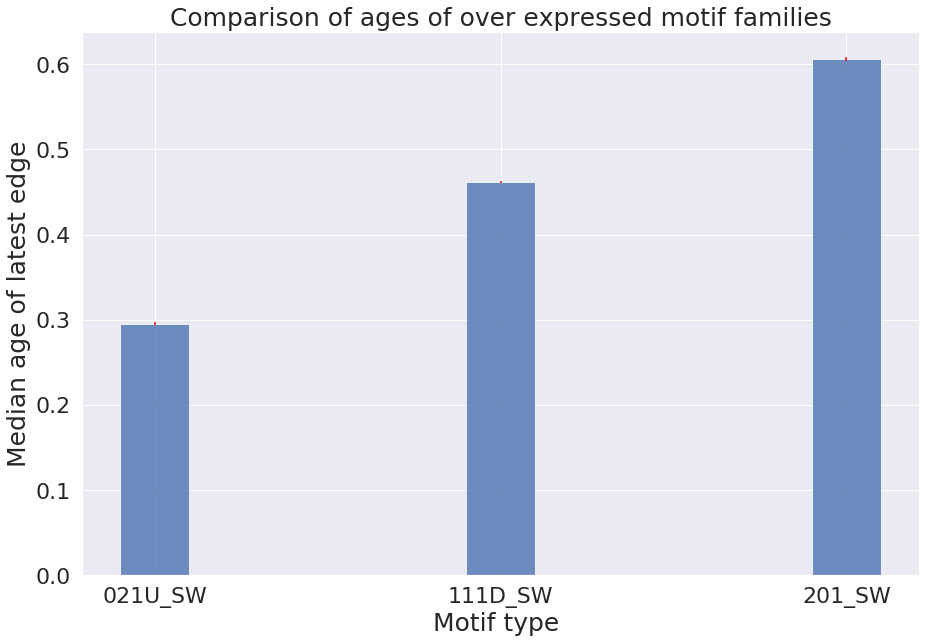

In [116]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
plt.title("Comparison of ages of over expressed motif families", fontsize = 25)
plt.xlabel("Motif type ",fontsize = 25)
plt.ylabel("Median age of latest edge" ,fontsize = 25)
x = np.arange(3)
y1 = [np.median(SW_motif_ages['021U']) , np.median(SW_motif_ages['111D']) , np.median(SW_motif_ages['201']) ]
y2 = [np.median(BL_motif_ages['021U']) , np.median(BL_motif_ages['111D']) , np.median(BL_motif_ages['201']) ]
errors = [sem(SW_motif_ages['021U']) , sem(SW_motif_ages['111D']) , sem(SW_motif_ages['201']) ]
errors_bl = [sem(BL_motif_ages['021U']) , sem(BL_motif_ages['111D']) , sem(BL_motif_ages['201']) ]


ax.bar(x, y1 ,width=0.2, color='b',yerr = errors, align='center', alpha=0.8, ecolor='red', capsize=2)

plt.xticks(np.arange(0,3,1) , ['021U_SW' , '111D_SW' , '201_SW'])
plt.show()

{'boxes': [<matplotlib.lines.Line2D at 0x7f9040790890>,
 'caps': [<matplotlib.lines.Line2D at 0x7f90408859d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f90409fca10>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f9040891550>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7f9040727a50>,
  <matplotlib.lines.Line2D at 0x7f9040a3cf50>]}

([<matplotlib.axis.XTick at 0x7f90407781d0>,
 <a list of 3 Text xticklabel objects>)

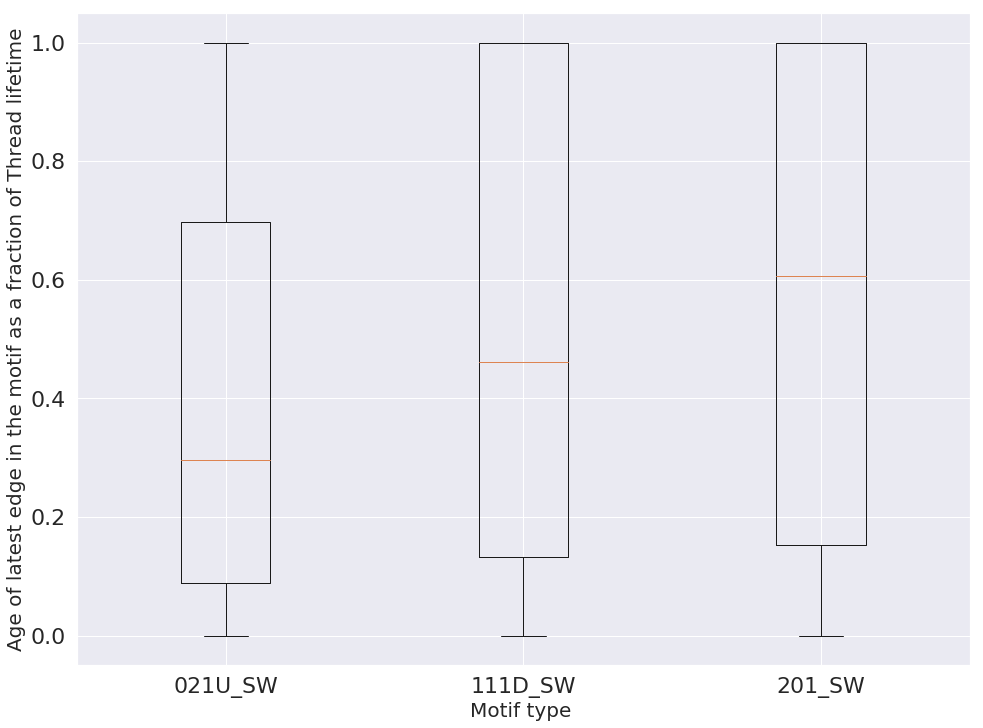

In [117]:
fig, ax = plt.subplots()
fig.set_size_inches(16,12)
data = [SW_motif_ages['021U'] , SW_motif_ages['111D'] , SW_motif_ages['201'] ]
data = [SW_motif_ages['021U'] , SW_motif_ages['111D'] , SW_motif_ages['201'] ]

# multiple box plots on one figure
plt.boxplot(data)
plt.xlabel("Motif type ",fontsize = 20)
# plt.ylabel("Rank of the latest message in motif, fraction of total messages",fontsize = 20)
plt.ylabel("Age of latest edge in the motif as a fraction of Thread lifetime",fontsize = 20)
# plt.xticks(np.arange(1,len(data)+1,1) , ['201_SW' , '111D_SW' , '021U_SW' ,'201_BL' , '111D_BL' , '021U_BL'])
plt.xticks(np.arange(1,len(data)+1,1) , ['021U_SW' , '111D_SW' , '201_SW'])
plt.show()

In [118]:
SW_lifetimes = getThreadLifeTimes(SW_Graphs)
BL_lifetimes = getThreadLifeTimes(BL_Graphs)
Dep_lifetimes = getThreadLifeTimes(Dep_Graphs)

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 <a list of 8 Text xticklabel objects>)

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 <a list of 8 Text yticklabel objects>)

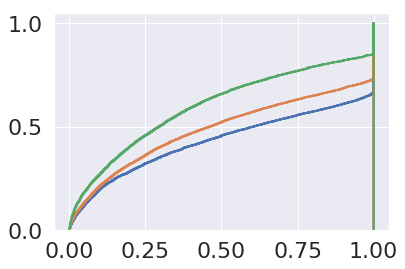

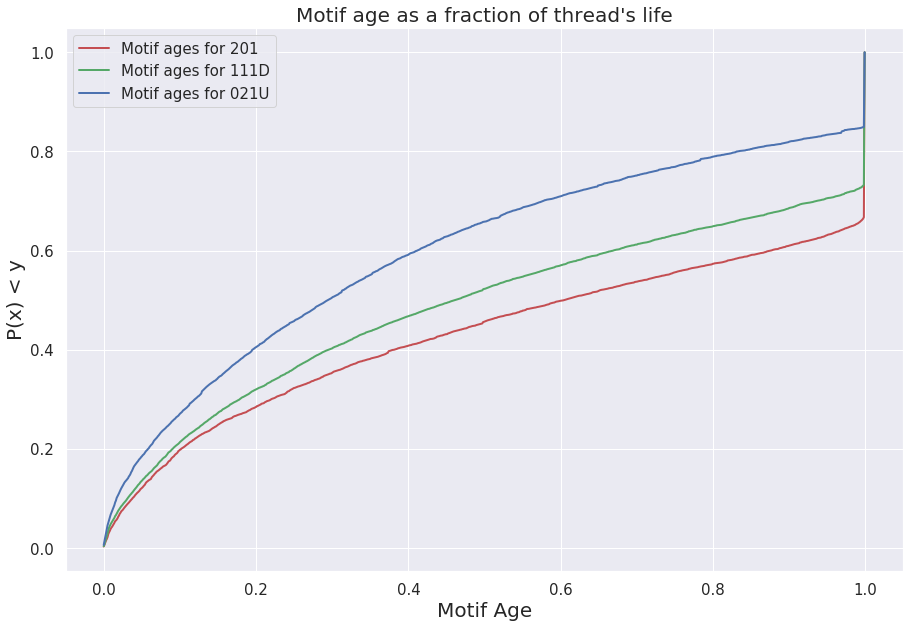

In [119]:
n1 , bins1 , patches1 = plt.hist(SW_motif_ages['201'], 1000, normed=1,histtype='step', cumulative=True,linewidth = 2.0)
n2 , bins2 , patches2 = plt.hist(SW_motif_ages['111D'], 1000, normed=1,histtype='step', cumulative=True,linewidth = 2.0)
n3 , bins3 , patches3 = plt.hist(SW_motif_ages['021U'], 1000, normed=1,histtype='step', cumulative=True,linewidth = 2.0)

fig, ax = plt.subplots()
fig.set_size_inches(15, 10)

ax.plot(bins1[:-1], n1, 'r', linewidth=2)
ax.plot(bins2[:-1], n2, 'g', linewidth=2)
ax.plot(bins3[:-1], n3, 'b', linewidth=2)

plt.title("Motif age as a fraction of thread's life", fontsize = 20)
plt.xlabel("Motif Age",fontsize = 20)
plt.ylabel("P(x) < y",fontsize = 20)
plt.legend(['Motif ages for 201','Motif ages for 111D' , 'Motif ages for 021U'], loc='top left',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.grid()
plt.show()

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.]),
 <a list of 11 Text xticklabel objects>)

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 <a list of 8 Text yticklabel objects>)

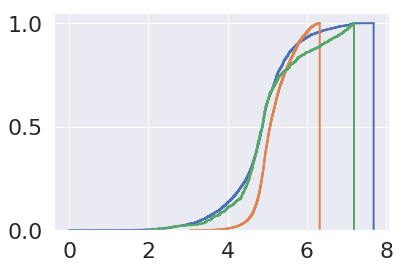

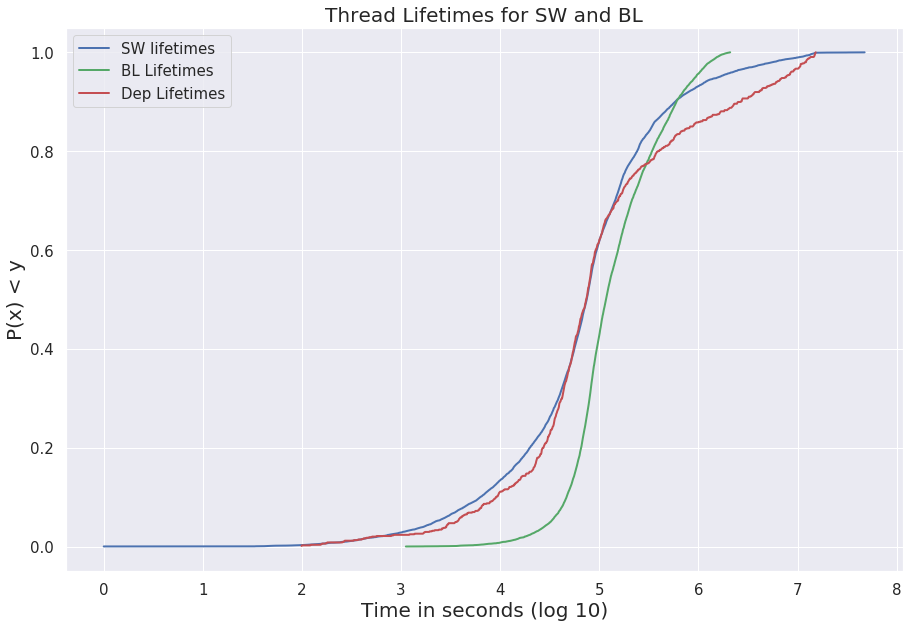

In [120]:
n1 , bins1 , patches1 = plt.hist(np.log10(SW_lifetimes), 1000, normed=1,histtype='step', cumulative=True,linewidth = 2.0)
n2 , bins2 , patches2 = plt.hist(np.log10(BL_lifetimes), 1000, normed=1,histtype='step', cumulative=True,linewidth = 2.0)
n3, bins3 , patches3 = plt.hist(np.log10(Dep_lifetimes), 1000, normed=1,histtype='step', cumulative=True,linewidth = 2.0)

fig, ax = plt.subplots()
fig.set_size_inches(15, 10)

ax.plot(bins1[:-1], n1, 'b', linewidth=2)
ax.plot(bins2[:-1], n2, 'g', linewidth=2)
ax.plot(bins3[:-1], n3, 'r', linewidth=2)

plt.title("Thread Lifetimes for SW and BL", fontsize = 20)
plt.xlabel("Time in seconds (log 10)",fontsize = 20)
plt.ylabel("P(x) < y",fontsize = 20)
plt.legend(['SW lifetimes' , 'BL Lifetimes' , 'Dep Lifetimes'], loc='top left',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.grid()
plt.show()

In [121]:
# ApexOpProportion = getApexNodeStat(SW_Graphs, triadNodes_SW,SW_OpAuthors)

# ApexOpProportion_BL = getApexNodeStat(BL_Graphs, triadNodes_BL, FP_OpAuthors)

# ApexOpProportion_Dep = getApexNodeStat(Dep_Graphs, triadNodes_Dep, Dep_OpAuthors)

In [122]:
# fig, ax = plt.subplots()
# fig.set_size_inches(16,12)
# data = [ApexOpProportion['201'], ApexOpProportion['111D'], ApexOpProportion['021U'] ]
# # multiple box plots on one figure
# plt.boxplot(data)
# plt.xlabel("Motif name (SW: Suicide Watch, BL: Baseline)",fontsize = 20)
# plt.ylabel("Proportion of motifs with OP at apex",fontsize = 20)
# plt.xticks(np.arange(1,len(data)+1,1) , ['201_SW' , '111D_SW' , '021U_SW' ,'201_BL' , '111D_BL' , '021U_BL'])
# plt.show()

In [123]:
# print np.median(ApexOpProportion['201']),np.median(ApexOpProportion['111D']),np.median(ApexOpProportion['021U']),np.median(ApexOpProportion['021D']),np.median(ApexOpProportion['021C']),np.median(ApexOpProportion['111U']),
# print np.mean(ApexOpProportion['201']),np.mean(ApexOpProportion['111D']),np.mean(ApexOpProportion['021U']),np.mean(ApexOpProportion['021D']),np.mean(ApexOpProportion['021C']),np.mean(ApexOpProportion['111U']),
# print "------------------------"
# print np.var(ApexOpProportion['201']),np.var(ApexOpProportion['111D']),np.var(ApexOpProportion['021U']),np.var(ApexOpProportion['021D']),np.var(ApexOpProportion['021C']),np.var(ApexOpProportion['111U']),

In [124]:
# print np.median(ApexOpProportion_BL['201']),np.median(ApexOpProportion_BL['111D']),np.median(ApexOpProportion_BL['021U']),np.median(ApexOpProportion_BL['021D']),np.median(ApexOpProportion_BL['021C']),np.median(ApexOpProportion_BL['111U']),
# print np.mean(ApexOpProportion_BL['201']),np.mean(ApexOpProportion_BL['111D']),np.mean(ApexOpProportion_BL['021U']),np.mean(ApexOpProportion_BL['021D']),np.mean(ApexOpProportion_BL['021C']),np.mean(ApexOpProportion_BL['111U']),
# print "------------------------"
# print np.var(ApexOpProportion_BL['201']),np.var(ApexOpProportion_BL['111D']),np.var(ApexOpProportion_BL['021U']),np.var(ApexOpProportion_BL['021D']),np.var(ApexOpProportion_BL['021C']),np.var(ApexOpProportion_BL['111U']),

In [125]:
# fig, ax = plt.subplots()
# fig.set_size_inches(16,12)
# # data = [SW_motif_ages['201'], SW_motif_ages['111D'], SW_motif_ages['021U'] , BL_motif_ages['201'], BL_motif_ages['111D'], BL_motif_ages['021U']]
# data = [ApexOpProportion['201'], ApexOpProportion['111D'], ApexOpProportion['021U'] , ApexOpProportion['021D'] , ApexOpProportion['021C'] , ApexOpProportion['111U']]
# # multiple box plots on one figure
# plt.boxplot(data)
# plt.xlabel("Motif type ",fontsize = 20)
# # plt.ylabel("Rank of the latest message in motif, fraction of total messages",fontsize = 20)
# plt.ylabel("Age of latest edge in the motif as a fraction of Thread lifetime",fontsize = 20)
# # plt.xticks(np.arange(1,len(data)+1,1) , ['201_SW' , '111D_SW' , '021U_SW' ,'201_BL' , '111D_BL' , '021U_BL'])
# plt.xticks(np.arange(1,len(data)+1,1) , ['201_SW' , '111D_SW' , '021U_SW' , '021D_SW' , '021C_SW' , '111U_SW' ])
# plt.show()

In [126]:
# n1 , bins1 , patches1 = plt.hist(ApexOpProportion['201'], 1000, normed=1,histtype='step', cumulative=True,linewidth = 2.0)
# n2 , bins2 , patches2 = plt.hist(ApexOpProportion['111D'], 1000, normed=1,histtype='step', cumulative=True,linewidth = 2.0)
# n3 , bins3 , patches3 = plt.hist(ApexOpProportion['021U'], 1000, normed=1,histtype='step', cumulative=True,linewidth = 2.0)

# fig, ax = plt.subplots()
# fig.set_size_inches(15, 10)

# ax.plot(bins1[:-1], n1, 'r', linewidth=2)
# ax.plot(bins2[:-1], n2, 'g', linewidth=2)
# ax.plot(bins3[:-1], n3, 'b', linewidth=2)

# plt.title("CDF for fraction of Apex nodes to be OP", fontsize = 20)
# plt.xlabel("Fraction of apex nodes to be OP",fontsize = 20)
# plt.ylabel("P(x) < y",fontsize = 20)
# plt.legend(['Fractions for 201','Fractions for 111D' , 'Fractions for 021U'], loc='top left',fontsize=15)
# plt.xticks(fontsize=15)
# plt.yticks(fontsize=15)
# # plt.grid()
# plt.show()

In [127]:
# print len(triads_SW), len(triads_BL)

In [128]:
# import json
# json.dump(triads_SW, open("SW_triadic_census_v2.json",'wb'))
# json.dump(triads_BL, open("BL_triadic_census_v2.json",'wb'))

In [129]:
# pkl.dump(file=open("SavedObjs/commonKeys_SW.pkl",'wb'),obj=commonKeys_SW)
# pkl.dump(file=open("SavedObjs/commonKeys_BL.pkl",'wb'),obj=commonKeys_BL)

# pkl.dump(file=open("SavedObjs/branching_BL.pkl",'wb'),obj=BL_branching)
# pkl.dump(file=open("SavedObjs/branching_SW.pkl",'wb'),obj=SW_branching)

In [130]:
# triad_names = ['003', '012', '102', '021D', '021U', '021C', '111D', '111U','030T', '030C', '201', '120D', '120U', '120C', '210', '300']
# dim = triad_names[7]
# SW_vals = [triads_SW[k][dim] for k in triads_SW]
# BL_vals = [triads_BL[k][dim] for k in triads_BL]

In [131]:
# print SW_repVals

In [132]:
# SW_repVals = [repTriads_SW[k][dim] for k in repTriads_SW]
# BL_repVals = [repTriads_BL[k][dim] for k in repTriads_BL]

In [133]:
# x , y = powerlaw.ccdf(SW_vals)
# x2,y2 = powerlaw.ccdf(BL_vals)

In [134]:
# plt.loglog(x,y)
# plt.loglog(x2,y2)
# plt.legend(['Suicide Watch Subreddit', 'Baseline Frontpage Subreddit'])

In [135]:
# fit_SW = powerlaw.Fit(SW_vals)
# fit_BL = powerlaw.Fit(BL_vals)

# fig, ax = plt.subplots()
# fig.set_size_inches(15, 10)
# plt.title("CCDF loglog scale: Triad Variant  : " + dim, fontsize = 25)
# plt.xlabel("Triad variant",fontsize = 20)
# plt.ylabel("CCDF",fontsize = 20)
# fig2=fit_SW.plot_ccdf(linewidth=2)
# fit_BL.plot_ccdf(color='r', linewidth=2, ax=fig2)
# plt.legend(['Suicide Watch Subreddit', 'Baseline Frontpage Subreddit'])

In [136]:
# fit_SW = powerlaw.Fit(SW_repVals)
# fit_BL = powerlaw.Fit(BL_repVals)

# fig, ax = plt.subplots()
# fig.set_size_inches(15, 10)
# plt.title("CCDF loglog scale: Triad Variant  : " + dim, fontsize = 25)
# plt.xlabel("Triad variant",fontsize = 20)
# plt.ylabel("CCDF",fontsize = 20)
# fig2=fit_SW.plot_ccdf(linewidth=2)
# fit_BL.plot_ccdf(color='r', linewidth=2, ax=fig2)
# plt.legend(['Suicide Watch Subreddit', 'Baseline Frontpage Subreddit'])

In [137]:
SW_sizes = {}
for k in commonKeys_SW:
    SW_sizes[k] = len(SW_Graphs[k].nodes())
BL_sizes = {}
for k in commonKeys_BL:
    BL_sizes[k] = len(BL_Graphs[k].nodes())

In [138]:
print len(SW_sizes), len(BL_sizes)

9857 11070


In [139]:


def getSizeDict(graphs):
    sizes = {}
    for k in graphs:
        sizes[k] = len(graphs[k].nodes())
    return sizes 

def getRandomGraphCensus(n , p , graphCount ):
    graphs= {}
    for k in range(graphCount):
        g = nx.erdos_renyi_graph(n, p, seed=None, directed=True)
        graphs[str(k)] = g
    randomCensus = getTriadicCensus(graphs)
    return randomCensus, graphs

def getRandomRangedGraphCensus(nstart , nstop ,  p,  graphCountPernode ):
    graphs= {}
    for k in range(nstart,nstop):
        for j in range(graphCountPernode):
            g = nx.erdos_renyi_graph(k, p, seed=None, directed=True)
            graphs[str(k) + '_' + str(j)] = g
    randomCensus = getTriadicCensus(graphs)
    return randomCensus, graphs
    
    
def getNodeMotifSpread(graphs , listSizeSpread):
    sizes = {}
    for k in graphs:
        sizes[k] = len(graphs[k].nodes())
    census_graph = {}
    census_random = {}
    #iterate through graph size spread
    for s in listSizeSpread:
        print "Working with Size %d" %s
        subset_graphs = dict()
        for k in sizes:
            if sizes[k] == s:
                subset_graphs[k] = graphs[k]
        print "Working with %d Selected Graphs" %len(subset_graphs.keys())
        randomCensus = getRandomGraphCensus(len(subset_graphs.keys()),0.2,s)
        graphCensus = getTriadicCensus(subset_graphs)
        
        census_graph[s] = graphCensus
        census_random[s] = randomCensus
    return census_graph , census_random

def getNodeMotifBinnedSpread(graphs , startNodeCount , stopNodeCount, binSize):
    sizes = {}
    for k in graphs:
        sizes[k] = len(graphs[k].nodes())
    census_graph = {}
    #iterate through graph size spread
    binCount = 0
    for (start,stop) in zip(range(startNodeCount,stopNodeCount,binSize),range(startNodeCount+binSize,stopNodeCount+binSize,binSize)):
        print "Working with Size %d - %d"%(start,stop)
        subset_graphs = dict()
        for k in sizes:
            if (sizes[k] > start and sizes[k]<=stop):
                subset_graphs[k] = graphs[k]
        print "Working with %d Selected Graphs" %len(subset_graphs.keys())
        
        graphCensus = getTriadicCensus(subset_graphs)
        census_graph[binCount] = graphCensus
        binCount+=1
    return census_graph , binCount


def createExpectedDegreeRGraphs(graphs, opDict):
    randomGraphs = {}
    randomOp = {}
    for g in graphs:
        indeg = graphs[g].in_degree()
        opIn = indeg[opDict[g]]
        outdeg =graphs[g].out_degree()
        opOut = indeg[opDict[g]]
        
        genGraph = nx.directed_configuration_model(indeg.values(),outdeg.values())
        randomGraphs[g] = genGraph
        randomOp[g] =  choice(genGraph.nodes())
        
    return randomGraphs , randomOp

    
def getUnrolledMotifBinnedSpread(graphs ,opDict, startNodeCount , stopNodeCount, binSize):
    sizes = {}
    for k in graphs:
        sizes[k] = len(graphs[k].nodes())
    census_graph = {}
    #iterate through graph size spread
    binCount = 0
    for (start,stop) in zip(range(startNodeCount,stopNodeCount,binSize),range(startNodeCount+binSize,stopNodeCount+binSize,binSize)):
        print "Working with Size %d - %d"%(start,stop)
        subset_graphs = dict()
        for k in sizes:
            if (sizes[k] > start and sizes[k]<=stop):
                subset_graphs[k] = graphs[k]
        print "Working with %d Selected Graphs" %len(subset_graphs.keys())
        
        graphCensus = getUnrolledTriadicCensus(subset_graphs,opDict)
        
        randomGraphs, randOP = createExpectedDegreeRGraphs(subset_graphs, opDict)
        randomCensus = getUnrolledTriadicCensus(randomGraphs,randOP)

        census_graph[binCount] = {}
        
        census_graph[binCount]['data'] = graphCensus
        census_graph[binCount]['random'] = randomCensus
        binCount+=1
    return census_graph , binCount


def getCountsForMotifs(censusSpread,MotifKey):
    Counts = {}
    errors = {}
    for k in censusSpread:
        presence = 0
        count = [0]
        for g in censusSpread[k][0]:
#             print censusSpread[k][0].keys()
            if censusSpread[k][0][g][MotifKey] > 0:
#                 presence+=censusSpread[k][g][MotifKey]
                count.append(censusSpread[k][0][g][MotifKey])
#         Counts[k] = float(presence)/float(len(censusSpread[k].keys()))
        Counts[k] = np.mean(count)
        errors[k] = sem(count)
    return Counts , errors

def getUnrolledCountsForMotifs(censusSpread,MotifKey):
    Counts = {}
    errors = {}
    for k in censusSpread:
        count = [[0], [0], [0], [0]]
        for g in censusSpread[k]['data']:
            for i in range(4):
                if censusSpread[k]['data'][g][MotifKey][i] > 0:
                    count[i].append(censusSpread[k]['data'][g][MotifKey][i])
        Counts[k] = [0, 0, 0, 0]
        errors[k] = [0, 0, 0, 0]
        for i in range(4):
            Counts[k][i] = np.mean(count[i])
            errors[k][i] = sem(count[i], nan_policy = 'omit')
    return Counts , errors

def getUnrolledZScore(censusSpread,MotifKey):
    Zscores = {}
    for k in censusSpread:
        count = [[0], [0], [0], [0]]
        random = [[0], [0], [0], [0]]
        for g in censusSpread[k]['data']:
            for i in range(4):
#                 if censusSpread[k]['data'][g][MotifKey][i] > 0:
                try:
                    count[i].append(censusSpread[k]['data'][g][MotifKey][i])
                    random[i].append(censusSpread[k]['random'][g][MotifKey][i])
                except:
                    print censusSpread[k] 

        Zscores[k] = [[], [], [], []]
        for i in range(4):
            mu = np.mean(random[i])
            std = np.std(random[i])
            if std == 0:
                std = 0.001
            median = np.mean(count[i])
#             for c in count[i]:
#                 Zscores[k][i].append((c-mu)/std)
            Zscores[k][i].append((median-mu)/std)
    return Zscores


def getUnrolledZScore_BLNullModel(censusSpread,BL_censusSpread ,MotifKey):
    Zscores = {}
    errors = {}
    for k in censusSpread:
        count = [[0], [0], [0], [0]]
        random = [[0], [0], [0], [0]]
        for g in censusSpread[k]['data']:
            for i in range(4):
                try:
                    count[i].append(censusSpread[k]['data'][g][MotifKey][i])
                except:
                    print censusSpread[k] 
        for g in BL_censusSpread[k]['data']:
            for i in range(4):
                try:
                    random[i].append(BL_censusSpread[k]['data'][g][MotifKey][i])
                except:
                    print BL_censusSpread[k] 

        Zscores[k] = [[], [], [], []]
        errors[k] = [[], [], [], []]
        for i in range(4):
            mu = np.mean(random[i])
            std = np.std(random[i])
            zscore = []
            if std == 0:
                std = 0.001
#             median = np.mean(count[i])
            for c in count[i]:
                zscore.append((c-mu)/std)
            Zscores[k][i].append(np.mean(zscore))
            errors[k][i] = sem(zscore, nan_policy = 'omit')
    return Zscores , errors



def getAllMotifCounts(spread , motifKey , nodeNumbers):
    counts = []
    for k in spread[nodeNumbers][0]:
        if motifKey in spread[nodeNumbers][0][k]:
            counts.append(spread[nodeNumbers][0][k][motifKey])
    return counts


def calculateZscore(TargetSpread , baselineSpread):
    triad_names = ['003', '012', '102', '021D', '021U', '021C', '111D', '111U','030T', '030C', '201', '120D', '120U', '120C', '210', '300']
    Zscores = {}
    for k in TargetSpread:
        for motifKey in triad_names:
            if motifKey not in Zscores:
                Zscores[motifKey] = []
            target = getAllMotifCounts(TargetSpread,motifKey,k)
            baseline = getAllMotifCounts(baselineSpread,motifKey,k)
            
            std = np.std(baseline)
            print std , len(baseline)
            
            z = (float(np.sum(target)) - float(np.sum(baseline)))/std
            Zscores[motifKey].append(z)
    return Zscores

In [140]:
# randomCensus, Randon_graphs = getRandomGraphCensus(30,0.3,100)
randomCensus, Random_graphs = getRandomRangedGraphCensus(3, 40,0.3,10)
    

No selector dictionary passed


In [141]:
# randomCensus[1]

In [142]:
# motifVals = [k['300'] for k in randomCensus]
SW_motifVals = [triads_SW[k]['300'] for k in  triads_SW if SW_sizes[k] == 30 ] 
BL_motifVals = [triads_BL[k]['300'] for k in  triads_BL if BL_sizes[k] == 30] 

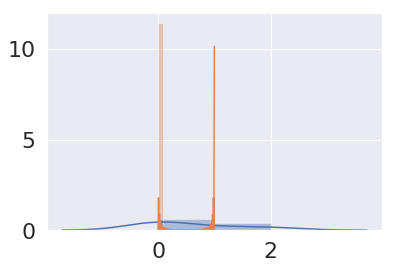

In [143]:
# sns.distplot(motifVals)
sns.distplot(SW_motifVals)
sns.distplot(BL_motifVals)

In [144]:
# SW_census_spread , R_census_spread = getNodeMotifSpread(SW_Graphs , [10 , 12 , 15 , 18 , 20 , 22 ,  25 , 28, 30])
SW_census_spread , bins = getNodeMotifBinnedSpread(SW_Graphs ,binSize=5 ,startNodeCount=1 , stopNodeCount=40)

Working with Size 1 - 6
Working with 6596 Selected Graphs
No selector dictionary passed
Working with Size 6 - 11
Working with 2926 Selected Graphs
No selector dictionary passed
Working with Size 11 - 16
Working with 674 Selected Graphs
No selector dictionary passed
Working with Size 16 - 21
Working with 192 Selected Graphs
No selector dictionary passed
Working with Size 21 - 26
Working with 65 Selected Graphs
No selector dictionary passed
Working with Size 26 - 31
Working with 36 Selected Graphs
No selector dictionary passed
Working with Size 31 - 36
Working with 11 Selected Graphs
No selector dictionary passed
Working with Size 36 - 41
Working with 10 Selected Graphs
No selector dictionary passed


In [145]:
SW_census_spread_unrolled , bins = getUnrolledMotifBinnedSpread(SW_Graphs , SW_OpAuthors, binSize=5 ,startNodeCount=1 , stopNodeCount=40)

Working with Size 1 - 6
Working with 6596 Selected Graphs
No selector dictionary passed
No selector dictionary passed
Working with Size 6 - 11
Working with 2926 Selected Graphs
No selector dictionary passed
No selector dictionary passed
Working with Size 11 - 16
Working with 674 Selected Graphs
No selector dictionary passed
No selector dictionary passed
Working with Size 16 - 21
Working with 192 Selected Graphs
No selector dictionary passed
No selector dictionary passed
Working with Size 21 - 26
Working with 65 Selected Graphs
No selector dictionary passed
No selector dictionary passed
Working with Size 26 - 31
Working with 36 Selected Graphs
No selector dictionary passed
No selector dictionary passed
Working with Size 31 - 36
Working with 11 Selected Graphs
No selector dictionary passed
No selector dictionary passed
Working with Size 36 - 41
Working with 10 Selected Graphs
No selector dictionary passed
No selector dictionary passed


In [146]:
SW_census_spread_unrolled[0]['random']

{'vj5co': {'003': [0, 0, 0, 0],
  '012': [0, 0, 1, 0],
  '021C': [0, 0, 0, 0],
  '021D': [0, 0, 0, 0],
  '021U': [0, 0, 0, 0],
  '030C': [0, 0, 0, 0],
  '030T': [0, 0, 0, 0],
  '102': [0, 2, 0, 0],
  '111D': [0, 0, 2, 0],
  '111U': [0, 0, 0, 0],
  '120C': [0, 0, 0, 0],
  '120D': [0, 0, 0, 0],
  '120U': [0, 0, 0, 0],
  '201': [1, 0, 0, 0],
  '210': [0, 0, 0, 0],
  '300': [0, 0, 0, 0]},
 '1uv2vj': {'003': [0, 0, 0, 0],
  '012': [0, 0, 5, 2],
  '021C': [0, 0, 0, 1],
  '021D': [0, 0, 0, 0],
  '021U': [0, 0, 0, 0],
  '030C': [0, 0, 0, 0],
  '030T': [0, 0, 0, 0],
  '102': [0, 0, 0, 0],
  '111D': [0, 0, 0, 0],
  '111U': [0, 0, 0, 0],
  '120C': [0, 0, 0, 0],
  '120D': [0, 0, 0, 0],
  '120U': [0, 0, 0, 0],
  '201': [0, 0, 0, 0],
  '210': [0, 0, 0, 0],
  '300': [0, 0, 0, 0]},
 '2mcsgu': {'003': [0, 0, 0, 0],
  '012': [0, 0, 0, 0],
  '021C': [0, 0, 0, 0],
  '021D': [0, 0, 0, 0],
  '021U': [0, 0, 0, 0],
  '030C': [0, 0, 0, 0],
  '030T': [0, 0, 0, 0],
  '102': [0, 0, 0, 0],
  '111D': [0, 0, 0, 0],


In [147]:
# BL_census_spread , R_census_spread = getNodeMotifSpread(BL_Graphs , [10 , 12 , 15 , 18 , 20 , 22 ,  25 , 28, 30])
BL_census_spread , bins = getNodeMotifBinnedSpread(BL_Graphs ,binSize=5 ,startNodeCount=1 , stopNodeCount=40)

Working with Size 1 - 6
Working with 107 Selected Graphs
No selector dictionary passed
Working with Size 6 - 11
Working with 1492 Selected Graphs
No selector dictionary passed
Working with Size 11 - 16
Working with 1907 Selected Graphs
No selector dictionary passed
Working with Size 16 - 21
Working with 1416 Selected Graphs
No selector dictionary passed
Working with Size 21 - 26
Working with 1029 Selected Graphs
No selector dictionary passed
Working with Size 26 - 31
Working with 737 Selected Graphs
No selector dictionary passed
Working with Size 31 - 36
Working with 672 Selected Graphs
No selector dictionary passed
Working with Size 36 - 41
Working with 458 Selected Graphs
No selector dictionary passed


In [148]:
BL_census_spread_unrolled , bins = getUnrolledMotifBinnedSpread(BL_Graphs , FP_OpAuthors , binSize=5 ,startNodeCount=1 , stopNodeCount=40)

Working with Size 1 - 6
Working with 107 Selected Graphs
No selector dictionary passed
No selector dictionary passed
Working with Size 6 - 11
Working with 1492 Selected Graphs
No selector dictionary passed
No selector dictionary passed
Working with Size 11 - 16
Working with 1907 Selected Graphs
No selector dictionary passed
No selector dictionary passed
Working with Size 16 - 21
Working with 1416 Selected Graphs
No selector dictionary passed
No selector dictionary passed
Working with Size 21 - 26
Working with 1029 Selected Graphs
No selector dictionary passed
No selector dictionary passed
Working with Size 26 - 31
Working with 737 Selected Graphs
No selector dictionary passed
No selector dictionary passed
Working with Size 31 - 36
Working with 672 Selected Graphs
No selector dictionary passed
No selector dictionary passed
Working with Size 36 - 41
Working with 458 Selected Graphs
No selector dictionary passed
No selector dictionary passed


In [149]:
Dep_census_spread_unrolled , bins = getUnrolledMotifBinnedSpread(Dep_Graphs , Dep_OpAuthors , binSize=5 ,startNodeCount=1 , stopNodeCount=40)

Working with Size 1 - 6
Working with 304 Selected Graphs
No selector dictionary passed
No selector dictionary passed
Working with Size 6 - 11
Working with 234 Selected Graphs
No selector dictionary passed
No selector dictionary passed
Working with Size 11 - 16
Working with 104 Selected Graphs
No selector dictionary passed
No selector dictionary passed
Working with Size 16 - 21
Working with 46 Selected Graphs
No selector dictionary passed
No selector dictionary passed
Working with Size 21 - 26
Working with 43 Selected Graphs
No selector dictionary passed
No selector dictionary passed
Working with Size 26 - 31
Working with 23 Selected Graphs
No selector dictionary passed
No selector dictionary passed
Working with Size 31 - 36
Working with 11 Selected Graphs
No selector dictionary passed
No selector dictionary passed
Working with Size 36 - 41
Working with 6 Selected Graphs
No selector dictionary passed
No selector dictionary passed


In [150]:
Dep_census_spread_unrolled[0]['random']

{u'53gjtb': {'003': [0, 0, 0, 0],
  '012': [1, 0, 3, 4],
  '021C': [0, 0, 0, 3],
  '021D': [0, 0, 0, 0],
  '021U': [3, 0, 0, 1],
  '030C': [0, 0, 0, 0],
  '030T': [0, 0, 0, 2],
  '102': [0, 0, 0, 0],
  '111D': [0, 0, 0, 0],
  '111U': [0, 0, 0, 0],
  '120C': [0, 0, 0, 0],
  '120D': [0, 0, 0, 0],
  '120U': [0, 0, 0, 0],
  '201': [0, 0, 0, 0],
  '210': [0, 0, 0, 0],
  '300': [0, 0, 0, 0]},
 u'5fs0y4': {'003': [0, 0, 0, 0],
  '012': [1, 0, 0, 0],
  '021C': [0, 0, 0, 0],
  '021D': [0, 0, 0, 0],
  '021U': [0, 0, 0, 0],
  '030C': [1, 0, 0, 0],
  '030T': [0, 0, 0, 0],
  '102': [0, 0, 0, 0],
  '111D': [0, 0, 0, 1],
  '111U': [1, 0, 0, 0],
  '120C': [0, 0, 0, 0],
  '120D': [0, 0, 0, 0],
  '120U': [0, 0, 0, 0],
  '201': [0, 0, 0, 0],
  '210': [0, 0, 0, 0],
  '300': [0, 0, 0, 0]},
 u'5gu7nx': {'003': [0, 0, 0, 0],
  '012': [0, 0, 0, 0],
  '021C': [0, 0, 0, 0],
  '021D': [0, 0, 0, 0],
  '021U': [0, 0, 0, 0],
  '030C': [0, 0, 0, 0],
  '030T': [0, 0, 0, 0],
  '102': [2, 3, 0, 2],
  '111D': [0, 0, 0, 

In [151]:
Dep_census_spread , bins = getNodeMotifBinnedSpread(Dep_Graphs ,binSize=5 ,startNodeCount=1 , stopNodeCount=40)

Working with Size 1 - 6
Working with 304 Selected Graphs
No selector dictionary passed
Working with Size 6 - 11
Working with 234 Selected Graphs
No selector dictionary passed
Working with Size 11 - 16
Working with 104 Selected Graphs
No selector dictionary passed
Working with Size 16 - 21
Working with 46 Selected Graphs
No selector dictionary passed
Working with Size 21 - 26
Working with 43 Selected Graphs
No selector dictionary passed
Working with Size 26 - 31
Working with 23 Selected Graphs
No selector dictionary passed
Working with Size 31 - 36
Working with 11 Selected Graphs
No selector dictionary passed
Working with Size 36 - 41
Working with 6 Selected Graphs
No selector dictionary passed


In [152]:
R_census_spread , bins = getNodeMotifBinnedSpread(Random_graphs ,binSize=5 ,startNodeCount=1 , stopNodeCount=40)

Working with Size 1 - 6
Working with 40 Selected Graphs
No selector dictionary passed
Working with Size 6 - 11
Working with 50 Selected Graphs
No selector dictionary passed
Working with Size 11 - 16
Working with 50 Selected Graphs
No selector dictionary passed
Working with Size 16 - 21
Working with 50 Selected Graphs
No selector dictionary passed
Working with Size 21 - 26
Working with 50 Selected Graphs
No selector dictionary passed
Working with Size 26 - 31
Working with 50 Selected Graphs
No selector dictionary passed
Working with Size 31 - 36
Working with 50 Selected Graphs
No selector dictionary passed
Working with Size 36 - 41
Working with 30 Selected Graphs
No selector dictionary passed


In [153]:
# R_census_spread[1]

In [154]:
# SW_census_spread[1][0]

In [155]:
SW_census_spread_unrolled[1]['data']['8e4oj']['030T']

[0, 0, 1, 0]

In [156]:
# BL_census_spread[1]

In [157]:
def getSequentialValues(presenceCensus , spread):
    return [presenceCensus[k] for k in spread]

def getSequentialValuesUnroll(presenceCensus , variant , spread):
    return [presenceCensus[k][variant] for k in spread]

def getErrorSlice(Errors, variant ,spread):
    return [Errors[k][variant] if Errors[k][variant] == Errors[k][variant] else 0 for k in spread ]

def getNonOPRatio(presenceCensus,spread):
    percentages = []
    for  k in presenceCensus:
        ratios = presenceCensus[k]
        opCentric = sum(ratios[:-1])
        nonOp = ratios[-1]
        percentages.append(float(nonOp)/float(opCentric+1.0))
    return percentages

In [158]:
def getXticks(startNodeCount , stopNodeCount, binSize):
    ticks = []
    for (start,stop) in zip(range(startNodeCount,stopNodeCount,binSize),range(startNodeCount+binSize,stopNodeCount+binSize,binSize)):
        ticks.append(str(start)+"-"+str(stop-1))
    return ticks

In [159]:
# import networkx as nx
# keys = my_triadic_census(BL_Graphs[BL_Graphs.keys()[160]]).keys()
# print keys

In [160]:

triad_names = ['003', '012', '102', '021D', '021U', '021C', '111D', '111U','030T', '030C', '201', '120D', '120U', '120C', '210', '300']

In [161]:
BL_opcentric_ratios = []
SW_opcentric_ratios = []
for k in range(len(triad_names)):
    dim = triad_names[k]
    BL_presenceRatio_unroll , BL_errors_unroll = getUnrolledCountsForMotifs(BL_census_spread_unrolled,dim)
    SW_presenceRatio_unroll, SW_errors_unroll = getUnrolledCountsForMotifs(SW_census_spread_unrolled,dim)
    
    BL_opcentric_ratios.append(getNonOPRatio(BL_presenceRatio_unroll, range(bins)))
    SW_opcentric_ratios.append(getNonOPRatio(SW_presenceRatio_unroll, range(bins)))

In [162]:
len(BL_opcentric_ratios)

16

([<matplotlib.axis.XTick at 0x7f9040edefd0>,
 <a list of 8 Text xticklabel objects>)

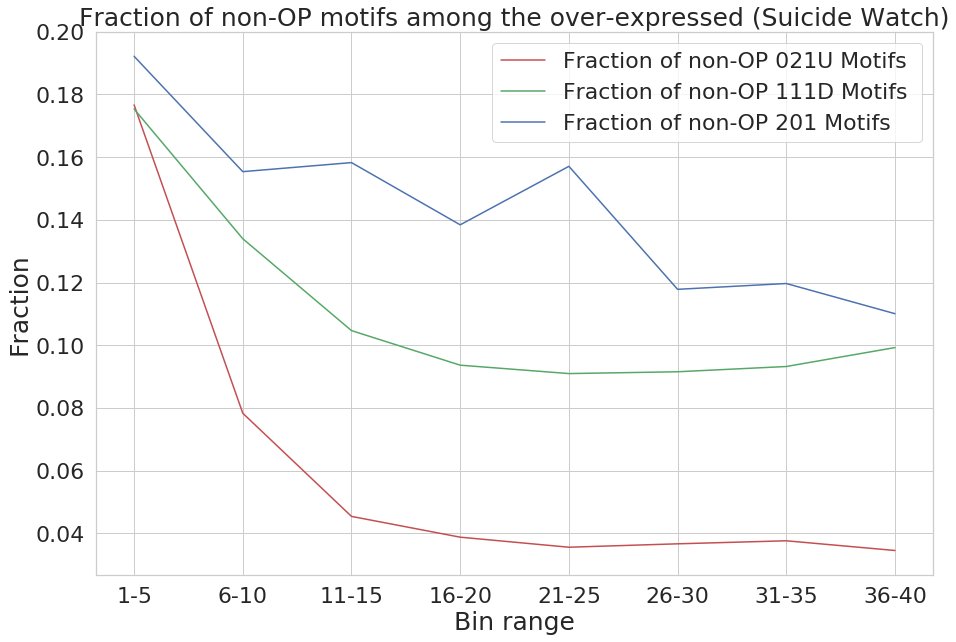

In [163]:
sns.set_style("whitegrid")
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
percentList = BL_opcentric_ratios
plt.title("Fraction of non-OP motifs among the over-expressed (Suicide Watch)" , fontsize = 25)
plt.xlabel("Bin range",fontsize = 25)
plt.ylabel("Fraction",fontsize = 25)
x = np.arange(bins)
y1 = percentList[4]
y2 = percentList[6]
y3 = percentList[10]


plt.plot(x,y1,color='r')
plt.plot(x,y2,color='g')
plt.plot(x,y3,color='b')
plt.xticks(np.arange(bins), getXticks(1,40,5))
plt.legend(['Fraction of non-OP 021U Motifs ','Fraction of non-OP 111D Motifs','Fraction of non-OP 201 Motifs'])

In [439]:
triad_names = ['003', '012', '102', '021D', '021U', '021C', '111D', '111U','030T', '030C', '201', '120D', '120U', '120C', '210', '300']
dim = triad_names[5]
BL_presenceRatio_unroll , BL_errors_unroll = getUnrolledCountsForMotifs(BL_census_spread_unrolled,dim)
SW_presenceRatio_unroll, SW_errors_unroll = getUnrolledCountsForMotifs(SW_census_spread_unrolled,dim)
# SW_presenceRatio_unroll, SW_errors_unroll = getUnrolledCountsForMotifs(Dep_census_spread_unrolled,dim)

In [440]:
BL_presence_Zscores = getUnrolledZScore(BL_census_spread_unrolled,dim)
SW_presence_Zscores = getUnrolledZScore(SW_census_spread_unrolled,dim)

SW_presence_Zscores_BL_NullModel , erros_Zscores_BL_NullModel = getUnrolledZScore_BLNullModel(SW_census_spread_unrolled,BL_census_spread_unrolled,dim)
# SW_presence_Zscores_BL_NullModel , erros_Zscores_BL_NullModel = getUnrolledZScore_BLNullModel(Dep_census_spread_unrolled,BL_census_spread_unrolled,dim)

In [441]:
# getSequentialValuesUnroll(SW_presence_Zscores, 0, range(bins))

In [442]:
# getSequentialValuesUnroll(SW_presence_Zscores_BL_NullModel, 1, range(bins))

In [443]:
# getErrorSlice(erros_Zscores_BL_NullModel,0,range(bins))

<Container object of 3 artists>

<Container object of 7 artists>

<Container object of 7 artists>

([<matplotlib.axis.XTick at 0x7f8bcd53d510>,
 <a list of 7 Text xticklabel objects>)

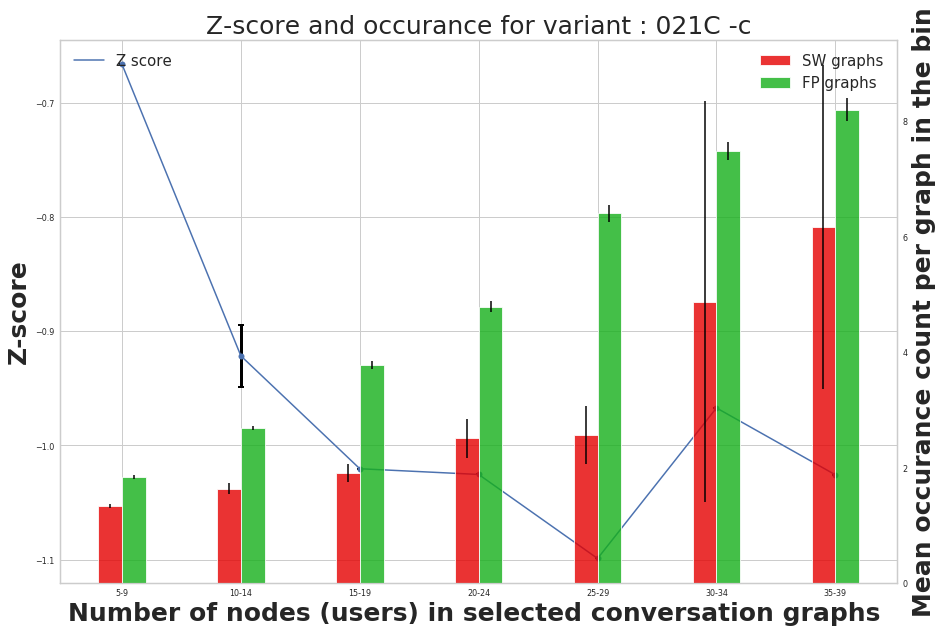

In [445]:
# sns.set_style("darkgrid")
sns.set_style("whitegrid")
fig, ax1 = plt.subplots()
fig.set_size_inches(15, 10)
# ax1.grid()

var = 2  # Variant of a motif 

varString = [' -a' , ' -b' , ' -c']

plt.title("Z-score and occurance for variant : " + dim  + varString[var], fontsize = 25)
# plt.title("Z-score and occurance for variant : " + dim  + "-s", fontsize = 25)

plt.xlabel("Number of nodes (users) in selected conversation graphs ",fontsize = 25)
ax1.set_ylabel("Z-score",fontsize = 25)

x = np.arange(bins-1)

y1 = getSequentialValuesUnroll(SW_presence_Zscores_BL_NullModel, var , range(bins))[1:]

ax1.errorbar(x, y1, yerr=getErrorSlice(erros_Zscores_BL_NullModel,0,range(bins))[1:], fmt='o',capsize=3 , capthick=2 , lw = 3, ecolor='black')
ax1.plot(x,y1,color='b')
ax1.legend(['Z score'] , loc =2 , fontsize = 15)
ax2 = ax1.twinx()
ax2.grid()
ax2.set_ylabel("Mean occurance count per graph in the bin",fontsize = 25)


y1_bar = getSequentialValuesUnroll(SW_presenceRatio_unroll, var, range(bins))
y2_bar = getSequentialValuesUnroll(BL_presenceRatio_unroll, var, range(bins))
ax2.bar(x-0.1, y1_bar[1:] ,width=0.2, color=mcd.XKCD_COLORS['xkcd:red'],yerr = getErrorSlice(SW_errors_unroll, var , range(bins))[1:], align='center', alpha=0.8, ecolor='black', capsize=2)
ax2.bar(x+0.1, y2_bar[1:] ,width=0.2, color=mcd.XKCD_COLORS['xkcd:green'],yerr = getErrorSlice(BL_errors_unroll, var , range(bins))[1:], align='center', alpha=0.8, ecolor='black', capsize=2)



plt.xticks(np.arange(bins-1), getXticks(5,40,5))
ax2.legend(['SW graphs', 'FP graphs'] , loc = 1,fontsize= 15)
# plt.legend(['Z-score variant - s'])

In [341]:
# fig, ax = plt.subplots()
# fig.set_size_inches(15, 10)
# plt.title("Z-score (BL null model) for motif variant   : " + dim , fontsize = 25)
# plt.xlabel("Number of nodes (users) in selected conversation graphs ",fontsize = 25)
# plt.ylabel("Z-score",fontsize = 25)
# x = np.arange(bins)
# y1 = getSequentialValuesUnroll(SW_presence_Zscores_BL_NullModel, 0, range(bins))
# y2 = getSequentialValuesUnroll(SW_presence_Zscores_BL_NullModel, 1, range(bins))
# y3 = getSequentialValuesUnroll(SW_presence_Zscores_BL_NullModel, 2, range(bins))

# plt.plot(x,y1,color='r')
# plt.plot(x,y2,color='g')
# plt.plot(x,y3,color='b')

# ax.errorbar(x, y1, yerr=getErrorSlice(erros_Zscores_BL_NullModel,0,range(bins)), fmt='o',capsize=3 , capthick=1 , lw = 1, ecolor='black')
# ax.errorbar(x, y2, yerr=getErrorSlice(erros_Zscores_BL_NullModel,1,range(bins)), fmt='o',capsize=3 , capthick=1 , lw = 1, ecolor='black')
# ax.errorbar(x, y3, yerr=getErrorSlice(erros_Zscores_BL_NullModel,2,range(bins)), fmt='o',capsize=3 , capthick=1 , lw = 1, ecolor='black')

# plt.xticks(np.arange(bins), getXticks(1,40,5))
# plt.legend(['Z-score variant - a','Z-score variant - b','Z-score variant - c'])
# # plt.legend(['Z-score variant - s'])

<Container object of 8 artists>

<Container object of 8 artists>

([<matplotlib.axis.XTick at 0x7f8bd459ff10>,
 <a list of 8 Text xticklabel objects>)

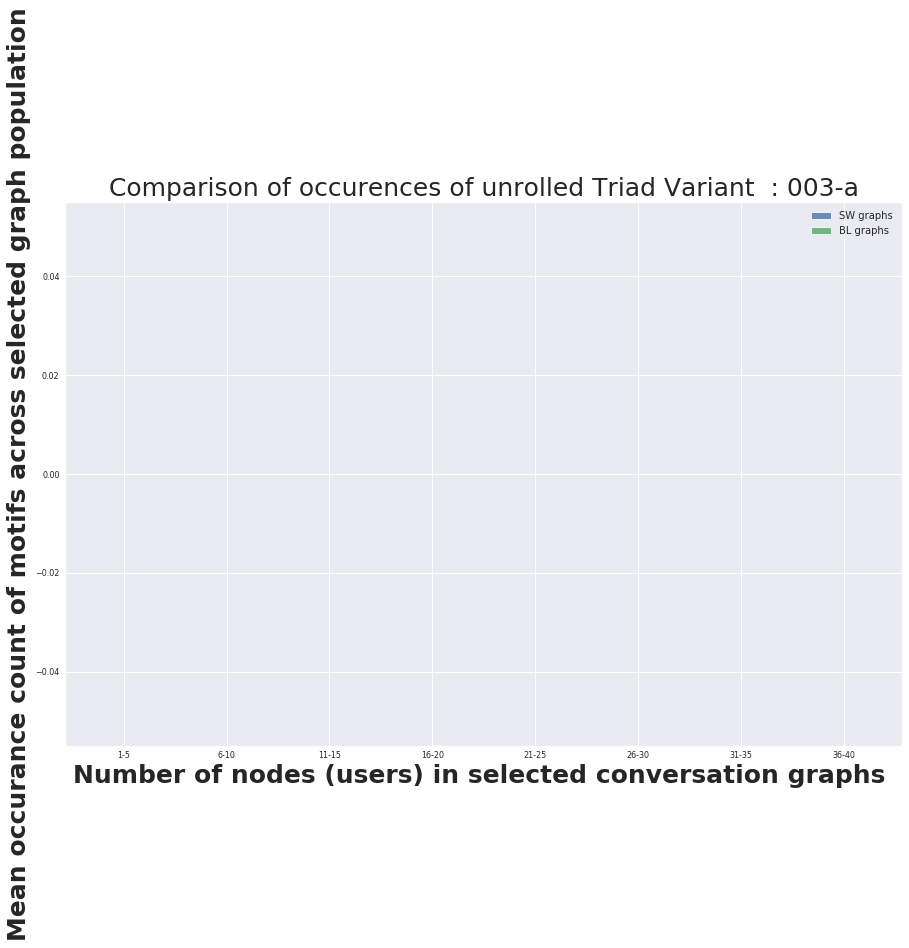

In [294]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
var =2
plt.title("Comparison of occurences of unrolled Triad Variant  : " + dim + '-a', fontsize = 25)
plt.xlabel("Number of nodes (users) in selected conversation graphs ",fontsize = 25)
plt.ylabel("Mean occurance count of motifs across selected graph population",fontsize = 25)
x = np.arange(bins)
y1 = getSequentialValuesUnroll(SW_presenceRatio_unroll, var, range(bins))
y2= getSequentialValuesUnroll(BL_presenceRatio_unroll, var, range(bins))
ax.bar(x-0.1, y1 ,width=0.2, color='b',yerr = getErrorSlice(SW_errors_unroll, var , range(bins)), align='center', alpha=0.8, ecolor='red', capsize=2)
ax.bar(x+0.1, y2 ,width=0.2, color='g',yerr = getErrorSlice(BL_errors_unroll, var , range(bins)), align='center', alpha=0.8, ecolor='red', capsize=2)
plt.xticks(np.arange(bins), getXticks(1,40,5))
plt.legend(['SW graphs', 'BL graphs',])

In [291]:
# dim = triad_names[2]
BL_presenceRatio , BL_errors = getCountsForMotifs(BL_census_spread,dim)
R_Ratio, R_errors = getCountsForMotifs(R_census_spread,dim)
SW_presenceRatio, SW_errors = getCountsForMotifs(SW_census_spread,dim)
Dep_presenceRatio, Dep_errors = getCountsForMotifs(Dep_census_spread,dim)

In [292]:
print BL_presenceRatio
print R_Ratio
print SW_presenceRatio

{0: 5.2254901960784315, 1: 62.350301406563965, 2: 249.30974842767296, 3: 724.53705010585747, 4: 1584.9155339805825, 5: 2992.4647696476964, 6: 5027.4026745913816, 7: 7835.167755991285}
{0: 2.2272727272727271, 1: 10.300000000000001, 2: 40.411764705882355, 3: 114.68627450980392, 4: 239.01960784313727, 5: 435.41176470588238, 6: 699.45098039215691, 7: 998.32258064516134}
{0: 4.071219512195122, 1: 44.501537410317731, 2: 239.29333333333332, 3: 701.53886010362692, 4: 1626.939393939394, 5: 2913.135135135135, 6: 4979.583333333333, 7: 6795.545454545455}


In [163]:
print BL_presenceRatio_unroll
print SW_presenceRatio_unroll

{0: [0.75, 0.0, 0.0, 0.0], 1: [0.90909090909090906, 0.0, 0.0, 0.0], 2: [1.0, 0.0, 0.0, 0.0], 3: [1.0512820512820513, 0.0, 0.0, 0.0], 4: [1.09375, 0.0, 0.0, 0.0], 5: [1.1538461538461537, 0.0, 0.0, 0.0], 6: [1.2916666666666667, 0.0, 0.0, 0.0], 7: [1.1333333333333333, 0.0, 0.0, 0.0]}
{0: [1.0186335403726707, 0.0, 0.0, 0.0], 1: [1.1228070175438596, 0.0, 0.0, 0.0], 2: [1.2413793103448276, 0.0, 0.0, 0.0], 3: [1.2380952380952381, 0.0, 0.0, 0.0], 4: [1.1666666666666667, 0.0, 0.0, 0.0], 5: [1.2857142857142858, 0.0, 0.0, 0.0], 6: [0.5, 0.0, 0.0, 0.0], 7: [2.6666666666666665, 0.0, 0.0, 0.0]}


In [164]:
getErrorSlice(SW_errors_unroll,0 , range(bins))

[0.013853855915028235,
 0.039678006277338834,
 0.12803144254548796,
 0.16768397011103817,
 0.30731814857642958,
 0.35951592548908334,
 0.5,
 2.1858128414340006]

In [165]:
print getSequentialValues(SW_presenceRatio, range(bins))#[10 , 12 , 15 , 18 , 20 , 22 ,  25 , 28, 30])
print getSequentialValues(BL_presenceRatio, range(bins))#[10 , 12 , 15 , 18 , 20 , 22 ,  25 , 28, 30])
print getSequentialValues(R_Ratio,range(bins))#[10 , 12 , 15 , 18 , 20 , 22 ,  25 , 28, 30])

[1.0186335403726707, 1.1228070175438596, 1.2413793103448276, 1.2380952380952381, 1.1666666666666667, 1.2857142857142858, 0.5, 2.6666666666666665]
[0.75, 0.90909090909090906, 1.0, 1.0512820512820513, 1.09375, 1.1538461538461537, 1.2916666666666667, 1.1333333333333333]
[0.0, 0.66666666666666663, 0.88888888888888884, 1.3888888888888888, 2.1499999999999999, 2.6888888888888891, 4.5, 7.0333333333333332]


In [166]:
SW_presenceRatio_unroll

{0: [1.0186335403726707, 0.0, 0.0, 0.0],
 1: [1.1228070175438596, 0.0, 0.0, 0.0],
 2: [1.2413793103448276, 0.0, 0.0, 0.0],
 3: [1.2380952380952381, 0.0, 0.0, 0.0],
 4: [1.1666666666666667, 0.0, 0.0, 0.0],
 5: [1.2857142857142858, 0.0, 0.0, 0.0],
 6: [0.5, 0.0, 0.0, 0.0],
 7: [2.6666666666666665, 0.0, 0.0, 0.0]}

<Container object of 8 artists>

<Container object of 8 artists>

([<matplotlib.axis.XTick at 0x7f9574d40550>,
 <a list of 8 Text xticklabel objects>)

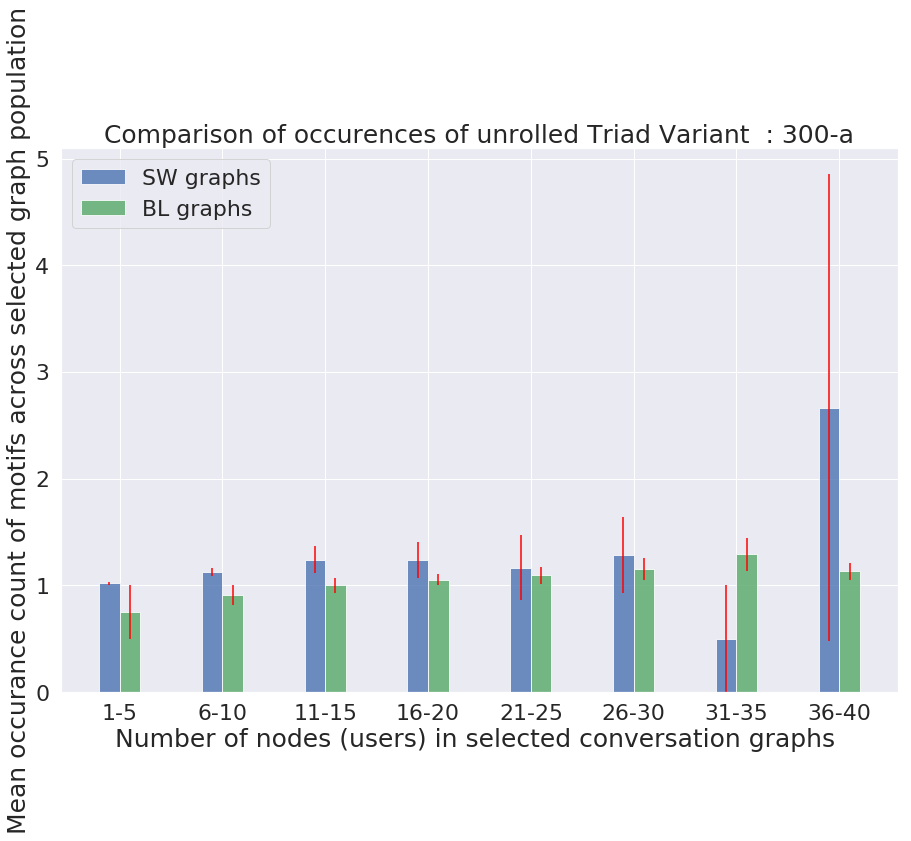

In [167]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
plt.title("Comparison of occurences of unrolled Triad Variant  : " + dim + '-a', fontsize = 25)
plt.xlabel("Number of nodes (users) in selected conversation graphs ",fontsize = 25)
plt.ylabel("Mean occurance count of motifs across selected graph population",fontsize = 25)
x = np.arange(bins)
y1 = getSequentialValuesUnroll(SW_presenceRatio_unroll, 0, range(bins))
y2= getSequentialValuesUnroll(BL_presenceRatio_unroll, 0, range(bins))
ax.bar(x-0.1, y1 ,width=0.2, color='b',yerr = getErrorSlice(SW_errors_unroll,0 , range(bins)), align='center', alpha=0.8, ecolor='red', capsize=2)
ax.bar(x+0.1, y2 ,width=0.2, color='g',yerr = getErrorSlice(BL_errors_unroll,0 , range(bins)), align='center', alpha=0.8, ecolor='red', capsize=2)
plt.xticks(np.arange(bins), getXticks(1,40,5))
plt.legend(['SW graphs', 'BL graphs',])

<Container object of 8 artists>

<Container object of 8 artists>

([<matplotlib.axis.XTick at 0x7f9574bc8550>,
 <a list of 8 Text xticklabel objects>)

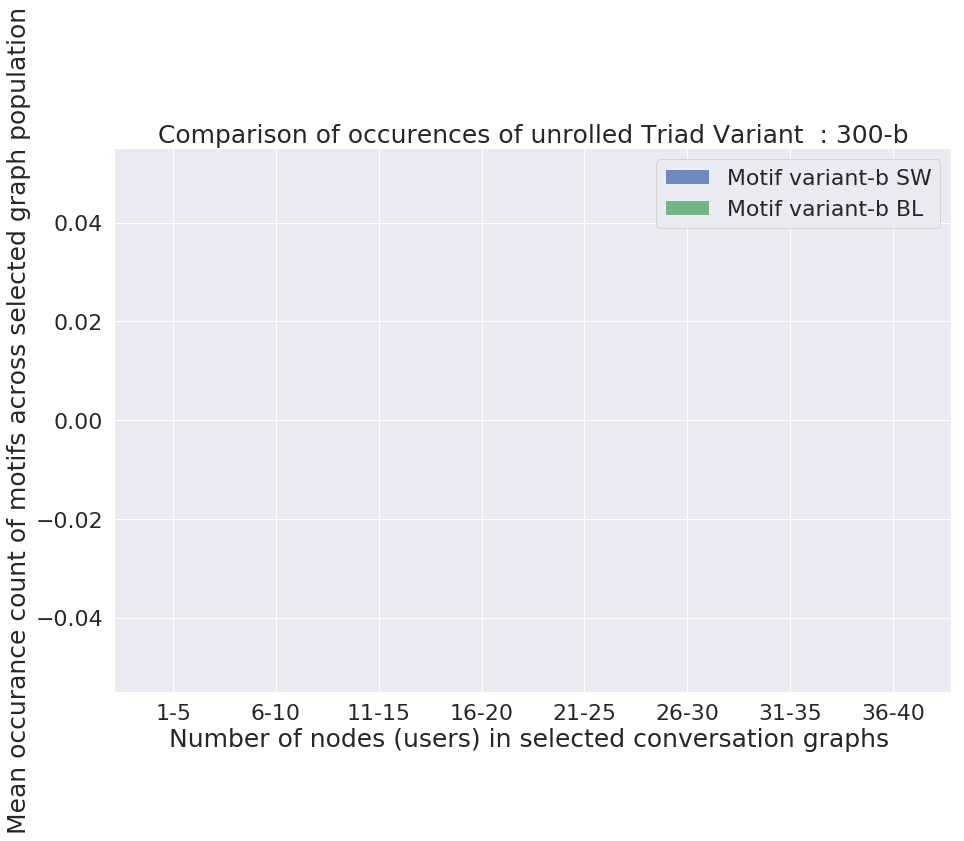

In [168]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
plt.title("Comparison of occurences of unrolled Triad Variant  : " + dim + '-b', fontsize = 25)
plt.xlabel("Number of nodes (users) in selected conversation graphs ",fontsize = 25)
plt.ylabel("Mean occurance count of motifs across selected graph population",fontsize = 25)
x = np.arange(bins)
y1 = getSequentialValuesUnroll(SW_presenceRatio_unroll, 1, range(bins))
y2= getSequentialValuesUnroll(BL_presenceRatio_unroll, 1, range(bins))
ax.bar(x-0.1, y1 ,width=0.2, color='b',yerr = getErrorSlice(SW_errors_unroll,1 , range(bins)), align='center', alpha=0.8, ecolor='red', capsize=2)
ax.bar(x+0.1, y2 ,width=0.2, color='g',yerr = getErrorSlice(BL_errors_unroll,1 , range(bins)), align='center', alpha=0.8, ecolor='red', capsize=2)
plt.xticks(np.arange(bins), getXticks(1,40,5))
plt.legend([ 'Motif variant-b SW' ,'Motif variant-b BL'])

<Container object of 8 artists>

<Container object of 8 artists>

([<matplotlib.axis.XTick at 0x7f9574be0950>,
 <a list of 8 Text xticklabel objects>)

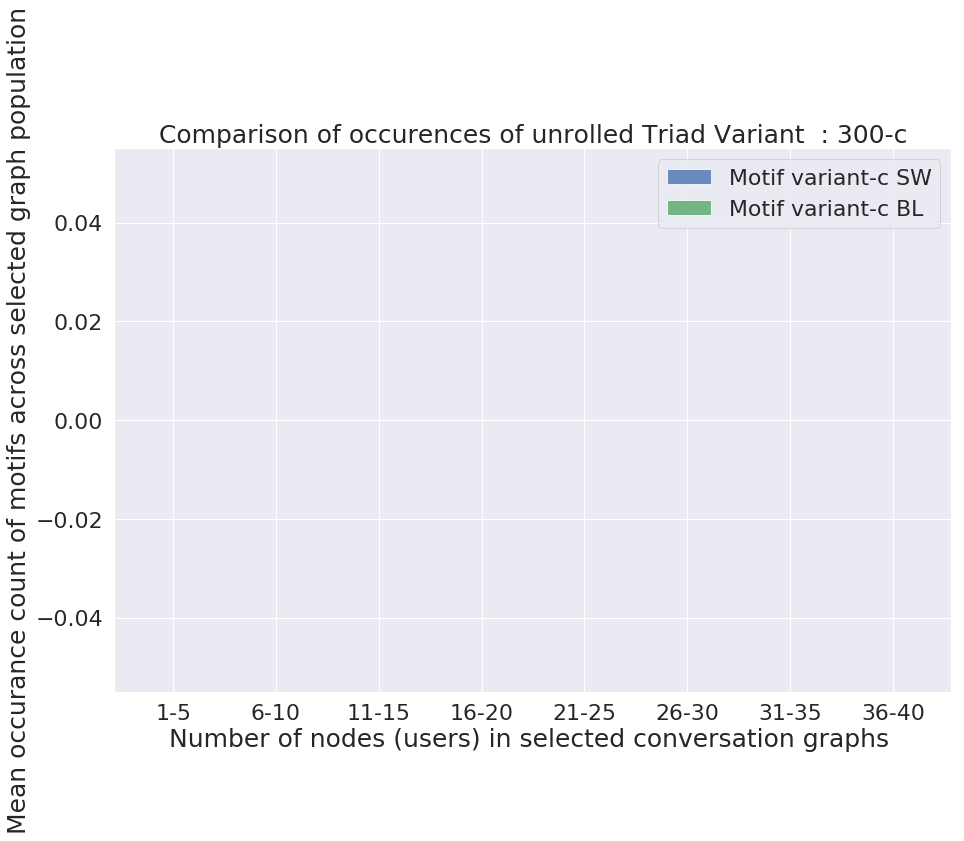

In [169]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
plt.title("Comparison of occurences of unrolled Triad Variant  : " + dim + '-c', fontsize = 25)
plt.xlabel("Number of nodes (users) in selected conversation graphs ",fontsize = 25)
plt.ylabel("Mean occurance count of motifs across selected graph population",fontsize = 25)
x = np.arange(bins)
y1 = getSequentialValuesUnroll(SW_presenceRatio_unroll, 2, range(bins))
y2= getSequentialValuesUnroll(BL_presenceRatio_unroll, 2, range(bins))
ax.bar(x-0.1, y1 ,width=0.2, color='b',yerr = getErrorSlice(SW_errors_unroll,2 , range(bins)), align='center', alpha=0.8, ecolor='red', capsize=2)
ax.bar(x+0.1, y2 ,width=0.2, color='g',yerr = getErrorSlice(BL_errors_unroll,2 , range(bins)), align='center', alpha=0.8, ecolor='red', capsize=2)
plt.xticks(np.arange(bins), getXticks(1,40,5))
plt.legend(['Motif variant-c SW','Motif variant-c BL'])

<Container object of 8 artists>

<Container object of 8 artists>

<Container object of 8 artists>

<Container object of 8 artists>

<Container object of 8 artists>

<Container object of 8 artists>

([<matplotlib.axis.XTick at 0x7f99c6ca8d90>,
 <a list of 8 Text xticklabel objects>)

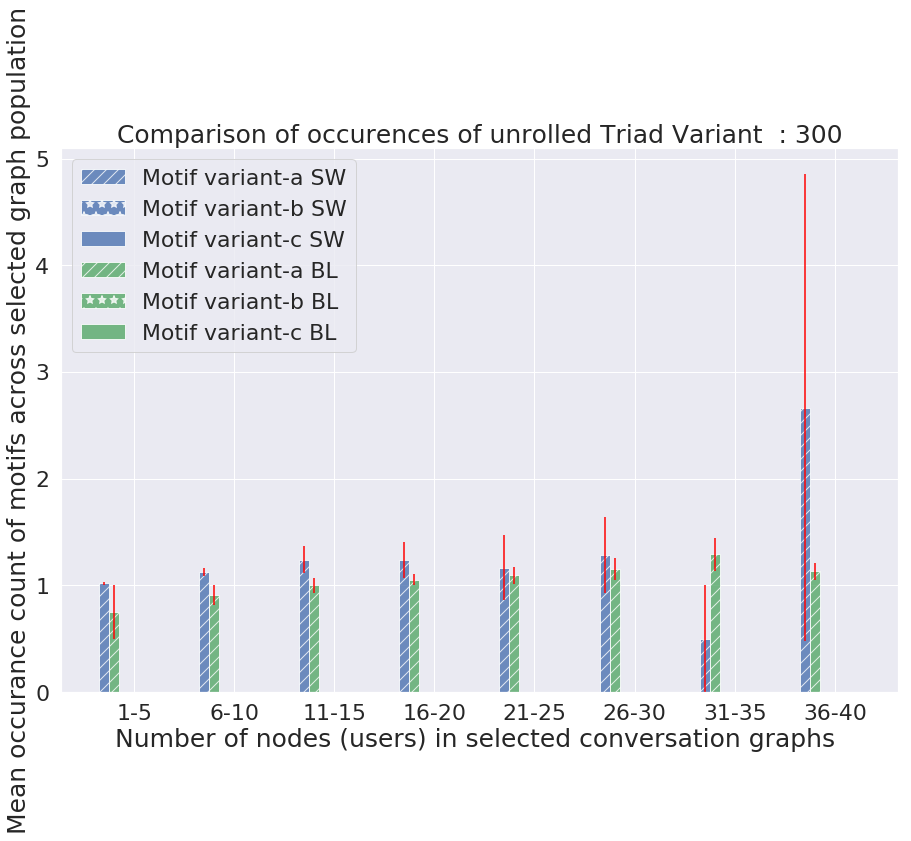

In [170]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
plt.title("Comparison of occurences of unrolled Triad Variant  : " + dim, fontsize = 25)
plt.xlabel("Number of nodes (users) in selected conversation graphs ",fontsize = 25)
plt.ylabel("Mean occurance count of motifs across selected graph population",fontsize = 25)
x = np.arange(bins)



y1 = getSequentialValuesUnroll(SW_presenceRatio_unroll, 0, range(bins))
y2 = getSequentialValuesUnroll(SW_presenceRatio_unroll,1, range(bins))
y3 = getSequentialValuesUnroll(SW_presenceRatio_unroll,2, range(bins))

y4= getSequentialValuesUnroll(BL_presenceRatio_unroll, 0, range(bins))
y5 = getSequentialValuesUnroll(BL_presenceRatio_unroll,1, range(bins))
y6 = getSequentialValuesUnroll(BL_presenceRatio_unroll,2, range(bins))


ax.bar(x-0.3, y1 ,width=0.1, color='b',yerr = getErrorSlice(SW_errors_unroll,0 , range(bins)), align='center', alpha=0.8, ecolor='red', capsize=2 , hatch = '//')
ax.bar(x-0.1, y2 ,width=0.1, color='b',yerr = getErrorSlice(SW_errors_unroll,1 , range(bins)), align='center', alpha=0.8, ecolor='red', capsize=2 , hatch = '*')
ax.bar(x+0.1, y3 ,width=0.1, color='b',yerr = getErrorSlice(SW_errors_unroll,2 , range(bins)), align='center', alpha=0.8, ecolor='red', capsize=2)

ax.bar(x-0.2, y4 ,width=0.1, color='g',yerr = getErrorSlice(BL_errors_unroll,0 , range(bins)), align='center', alpha=0.8, ecolor='red', capsize=2 , hatch = '//')
ax.bar(x, y5 ,width=0.1, color='g',yerr = getErrorSlice(BL_errors_unroll,1 , range(bins)), align='center', alpha=0.8, ecolor='red', capsize=2 , hatch = '*')
ax.bar(x+0.2, y6 ,width=0.1, color='g',yerr = getErrorSlice(BL_errors_unroll,2 , range(bins)), align='center', alpha=0.8, ecolor='red', capsize=2)

plt.xticks(np.arange(bins), getXticks(1,40,5))
plt.legend(['Motif variant-a SW', 'Motif variant-b SW' , 'Motif variant-c SW', 'Motif variant-a BL', 'Motif variant-b BL' , 'Motif variant-c BL'])

<Container object of 8 artists>

<Container object of 8 artists>

([<matplotlib.axis.XTick at 0x7f95748fc3d0>,
 <a list of 8 Text xticklabel objects>)

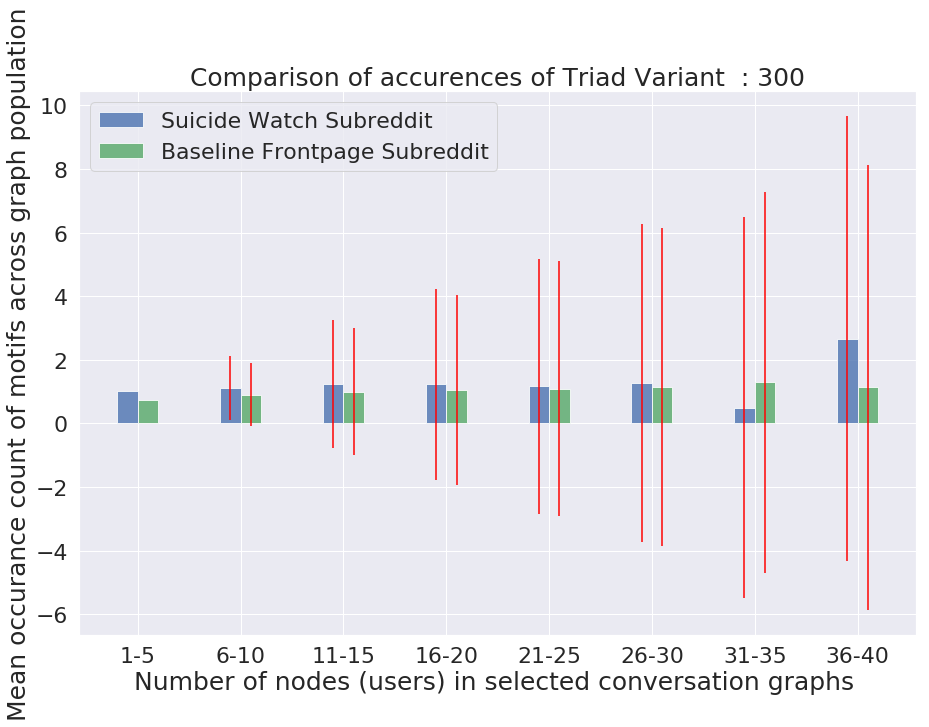

In [171]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
plt.title("Comparison of accurences of Triad Variant  : " + dim, fontsize = 25)
plt.xlabel("Number of nodes (users) in selected conversation graphs ",fontsize = 25)
plt.ylabel("Mean occurance count of motifs across graph population",fontsize = 25)
x = np.arange(bins)
y1 = getSequentialValues(SW_presenceRatio, range(bins))
y2 = getSequentialValues(BL_presenceRatio, range(bins))
# y3 = getSequentialValues(R_Ratio, range(bins))
ax.bar(x-0.1, y1 ,width=0.2, color='b',yerr = SW_errors, align='center', alpha=0.8, ecolor='red', capsize=10)
ax.bar(x+0.1, y2 ,width=0.2, color='g',yerr = BL_errors, align='center', alpha=0.8, ecolor='red', capsize=10)
# ax.bar(x+0.3, y3 ,width=0.2, color='r',yerr = R_errors, align='center', alpha=0.5, ecolor='black', capsize=10)

# plt.plot(getSequentialValues(SW_presenceRatio, range(bins)))#[10 , 12 , 15 , 18 , 20 , 22 ,  25 , 28, 30]))
# plt.errorbar(getSequentialValues(SW_presenceRatio, range(bins)), np.arange(1,40,3), yerr=SW_errors, fmt='.k')
# plt.plot(getSequentialValues(BL_presenceRatio, range(bins)))#[10 , 12 , 15 , 18 , 20 , 22 ,  25 , 28, 30]))

plt.xticks(np.arange(bins), getXticks(1,40,5))
plt.legend(['Suicide Watch Subreddit', 'Baseline Frontpage Subreddit' ])

<Container object of 8 artists>

<Container object of 8 artists>

<Container object of 8 artists>

([<matplotlib.axis.XTick at 0x7f95745705d0>,
 <a list of 8 Text xticklabel objects>)

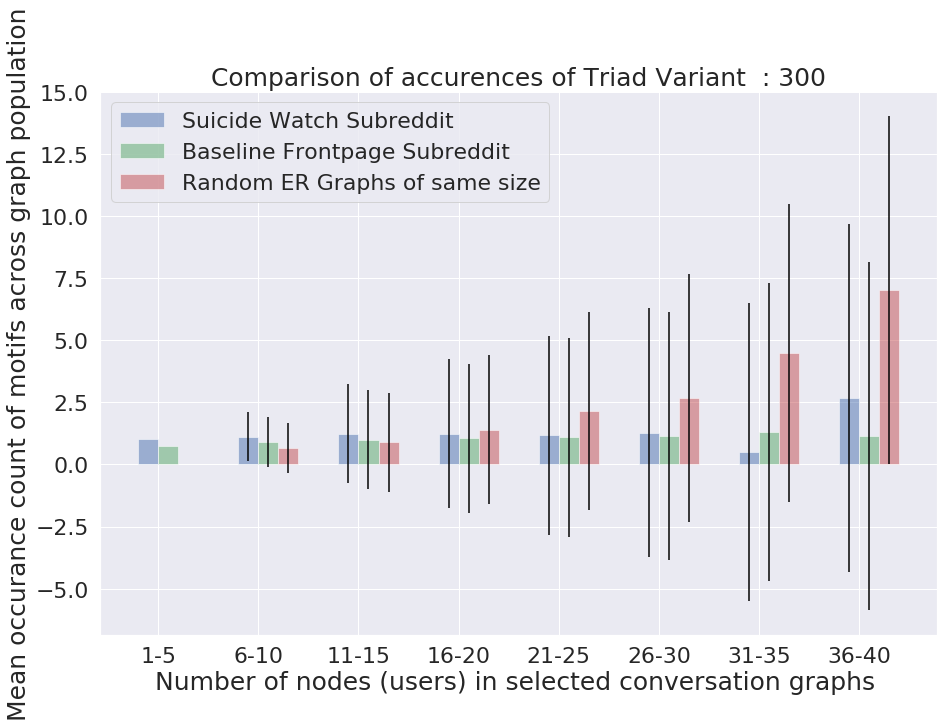

In [172]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
plt.title("Comparison of accurences of Triad Variant  : " + dim, fontsize = 25)
plt.xlabel("Number of nodes (users) in selected conversation graphs ",fontsize = 25)
plt.ylabel("Mean occurance count of motifs across graph population",fontsize = 25)
x = np.arange(bins)
y1 = getSequentialValues(SW_presenceRatio, range(bins))
y2 = getSequentialValues(BL_presenceRatio, range(bins))
y3 = getSequentialValues(R_Ratio, range(bins))
ax.bar(x-0.1, y1 ,width=0.2, color='b',yerr = SW_errors, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.bar(x+0.1, y2 ,width=0.2, color='g',yerr = BL_errors, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.bar(x+0.3, y3 ,width=0.2, color='r',yerr = R_errors, align='center', alpha=0.5, ecolor='black', capsize=10)

# plt.plot(getSequentialValues(SW_presenceRatio, range(bins)))#[10 , 12 , 15 , 18 , 20 , 22 ,  25 , 28, 30]))
# plt.errorbar(getSequentialValues(SW_presenceRatio, range(bins)), np.arange(1,40,3), yerr=SW_errors, fmt='.k')
# plt.plot(getSequentialValues(BL_presenceRatio, range(bins)))#[10 , 12 , 15 , 18 , 20 , 22 ,  25 , 28, 30]))

plt.xticks(np.arange(bins), getXticks(1,40,5))
plt.legend(['Suicide Watch Subreddit', 'Baseline Frontpage Subreddit' , 'Random ER Graphs of same size'])

In [173]:
# fig, ax = plt.subplots()
# fig.set_size_inches(15, 10)
# plt.title("Comparison of accurences of Triad Variant  : " + dim, fontsize = 25)
# plt.xlabel("Number of Nodes in Selected Graphs ",fontsize = 25)
# plt.ylabel("Fraction of Graphs with motif present",fontsize = 25)
# plt.xticks(np.arange(8),[10 , 12 , 15 , 18 , 20 , 22 ,  25 , 28, 30])
# SW_result = getSequentialValues(SW_presenceRatio,[10 , 12 , 15 , 18 , 20 , 22 ,  25 , 28, 30])
# BL_result = getSequentialValues(BL_presenceRatio,[10 , 12 , 15 , 18 , 20 , 22 ,  25 , 28, 30])
# plt.plot([SW_result[i]/BL_result[i] for i in range(len(BL_result))])
# plt.legend(['Ratio of Motif foound in SW to those in BL'])

In [177]:
# triads = nx.triads.triad_graphs()

In [178]:
Zscores_SW = calculateZscore(SW_census_spread,R_census_spread)
Zscores_BL = calculateZscore(BL_census_spread,R_census_spread)

1.11355287257 40
2.48985441341 40
1.01980390272 40
1.0219466718 40
0.92736184955 40
1.29903810568 40
0.74161984871 40
0.734846922835 40
0.969535971483 40
0.622494979899 40
0.217944947177 40
0.523808170994 40
0.379967103839 40
0.446514277487 40
0.263391343821 40
0.0 40
8.1457719094 50
14.4416065588 50
6.28063691038 50
4.14226990912 50
3.76297754445 50
7.77660594347 50
4.05462698654 50
4.04969134626 50
3.99619819328 50
1.59762323468 50
1.30904545376 50
1.24643491607 50
0.966643677888 50
1.80011110768 50
1.44899965493 50
0.195959179423 50
22.3168904644 50
43.4517157314 50
10.6174384858 50
9.30051611471 50
9.49450367318 50
19.9345027528 50
8.35705689821 50
7.2394751191 50
10.8392619675 50
3.6 50
2.91677904545 50
2.71322686114 50
2.58216963037 50
4.95778176204 50
2.58456959666 50
0.366606055596 50
45.5319184748 50
78.9402710915 50
20.0485809972 50
19.0273592492 50
18.2211854719 50
35.0508430712 50
18.2041863317 50
16.5910939965 50
21.8775135699 50
7.55462772081 50
5.81047330258 50
5.3877267

In [180]:
Zscores_BL

{'003': [457.09549365814212,
  11353.742902284557,
  21212.81191728701,
  22420.27206835058,
  23332.443859825005,
  23559.511222736372,
  22231.353215593408,
  28770.759036083822],
 '012': [32.532022580756923,
  1872.92181723818,
  2442.7343826003503,
  2254.7807036750683,
  1856.6151743496828,
  1357.8900495777291,
  1141.1226565168627,
  1307.1655801971162],
 '021C': [-16.935607896229023,
  221.69054373236224,
  196.29283200742128,
  37.573989228325964,
  -92.062950344969579,
  -194.05892628239232,
  -273.67652536208703,
  -233.92852039148099],
 '021D': [-20.54901745806648,
  -37.419097113575916,
  -96.12369775758134,
  -142.42649042887507,
  -232.63586851044997,
  -258.17230204047644,
  -343.69395309276535,
  -295.01817423268284],
 '021U': [64.699663922063053,
  4166.9129870694342,
  5533.4119411017155,
  3687.4110141601845,
  2585.5344969138055,
  1398.5788383620891,
  1287.8600064262416,
  1226.9036075801534],
 '030C': [-12.851509262439983,
  -25.037192206289326,
  -71.1111111111

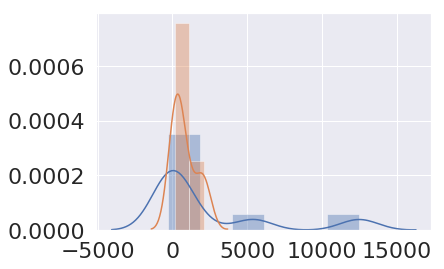

In [181]:
sns.distplot([Zscores_SW['111D']])
sns.distplot([Zscores_BL['111D']])

In [ ]:
# fig, ax = plt.subplots()
# fig.set_size_inches(15, 10)
# pos = graphviz_layout(triads[triad_names[6]], prog='neato')
# nx.draw(triads[triad_names[6]], pos=pos ,node_size=1500)